In [1]:
# #%% 

# WEB 
publish_on_web = True

# OS
import os
import sys
import urllib
import requests
import copy

import operator as op

# LOGGING / MONITORING
import inspect
import tqdm
from tqdm.notebook import tqdm_notebook
import time
from datetime import datetime

# redis - dictionary
import redis


# PROCESSING
import random
import numpy as np
import pandas as pd
import scipy
import collections
from collections import Counter


# MODELS / FITTING
from scipy.cluster import hierarchy

# GEO / TIME
import addfips

# NETWORK GRAPHS
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import write_dot

# DATABASE + I/O
import io
import base64
import pickle

## mongo
import pymongo
from pymongo import MongoClient
import bson.json_util as bj
## json
import json
from json import dumps
from bson import ObjectId



# NLP
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
stopw = set(stopwords.words("english"))

# function for cleaning each sentence
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

# spaCy / textacy
import spacy
from spacy import displacy
import nltk
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import textacy

# GRAPHICS
import seaborn as sns
from matplotlib import pyplot as plt

## plotly dash

import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
# import dash_bio as dashbio
import dash_table
import dash_table.FormatTemplate as FormatTemplate
from dash_table.Format import Sign
from dash.dependencies import Input, Output, State
from dash.exceptions import PreventUpdate

import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.express as px

with open('mapboxtoken.txt','r') as file:
    mapboxtoken = file.read()
file.close()

## download csv 
from six.moves.urllib.parse import quote

# LocalModules (sub-directory)
from LocalModules.GeoMap import GeoID
from LocalModules.MatrixFactorization import *
import LocalModules.GovData as gd
gd.onet.occupation_data =  gd.onet.data('Occupation Data').set_index('O*NET-SOC Code')[['Title','Description']].T


# CREATE PATHS / DIRECTORIES 

# path to home directory (the location of this file)

path = os.path.curdir
paths = {}
paths['.'] = os.path.curdir
paths['data'] = './data'
paths['session_containers'] = './session_containers'

#Check if directories exist - creat directories if needed
[os.makedirs(pth, exist_ok=True) for pth in paths.values()]

# GENERAL DICTIONARIES
session = {}

class JobDescriptions:
    '''
    JobDescriptions(db,client,collection) creates an instance of a MongoDB Collection
    containing job ads/descriptions.
    
    ## Connecting the database
    
    input    : client        = name of Mongo Client   : 'mongodb://localhost:27017/' 
    attribute: jd.client     = MongoClient(client)  
    
    input    : db            = name of Mongo database : 'job_db'
    attribute: jd.db         = jd.client[db]
    
    input    : collection    = name of db-collection  : 'ServicebusCreateMessage'
    attribute: jd.collection = jd.db[collection]
    
    ## Key attributes and functions:    
    
    jd.get()                    : get 'max_items' job descriptions with 'string' in 'field'
                                  places the dataset at the top of the stack. 
    jd.mark_duplicates()        : adds column to jd.df marking duplicate job descriptions
    jd.drop_duplicates()        : removes duplicate job descriptions from jd.df 
    jd.common_titles_count()    : counts occurences of job-title n-grams in jd.get()
    
      jd.params                 : parameters for current jd.get()
      jd.df                     : current jd.get(jd.params) job descriptions as dataframe 
      jd.common_titles          : result from latest common_titles_count()
      
  
    
    
    
    
    '''
    def __init__(self,                                         \
                 db              = 'job_db',                        \
                 client          = 'mongodb://localhost:27017/',    \
                 collection      = 'ServicebusCreateMessage',       \
                 data_path       = './data',                        \
                 geoid_entities  = ['counties'],                    \
                 uid             = False  ):
        
        self.client     = MongoClient(client)
        self.db         = self.client[db]
        self.collection = self.db[collection]
        self.collection.doc_count = self.collection.estimated_document_count()      
        self.geo        = GeoID(path = data_path, entities = geoid_entities)
        self.uid        = uid
        # self.geoid      = self.GeoID(path = data_path, entities = geoid_entities)
        
        # Dictionaries: Function Caches
        # key named 'params' in functions
        self.get_dic                    = {}
        self.duplicates_dic             = {}
        self.common_titles_dic          = {}
        self.word_set_matrix_dic        = {}
        self.cluster_dic                = {}
        self.classify_job_description_dic = {}
        self.ngram_analysis_dic         = {}
        
        self.current_parameters         = {}

        self.title_dic                  = {}
        self.common_dic                 = {}




    def get(self, string = 'manager', field = 'Title', max_items = 10000, uid=''):
        '''
        1. Gathers job descriptions in MongoDB "collection" for jobs with the sub-string 'string' in the job title. 
                Speeds up by indexing 'collection' on job titles if index does not already exist 
                - THIS TAKES TIME, but does only need to be done once for a collection.
        2. Parses gathered job descriptions into dictionaries

        Returns Pandas Dataframe with columns = [ObjectId, 
                                                time stamp, 
                                                title, 
                                                title set,
                                                company,
                                                description,
                                                length, (#characters in clean description )
                                                parsed description,
                                                all bullet headers
                                                word_set]
        '''
        uid = self.uid
        regis = session[uid].regis
        
        # Check if result already in dictionary
        par = {'string':string,'field':field,'max_items':max_items}
        self.current_parameters.update(par)
        self.params = str(par)
        params = self.params
        # If not in dictionary, connect to database and proceed...
        if params not in self.get_dic:
            collection = self.collection
            
            # Gather records with "string" in job title
            
            ## JUPYTER NOTEBOOK Indexing : weird - indexing of 'Description' works in notebook, not in Dash app
            # if field is 'Description':
            #     collection.create_index([('Message.'+field,pymongo.TEXT)]) 
            # else:
            #     collection.create_index('Message.'+field)

            cursor = collection.find({'Message.'+field:{'$regex':"(?i).*"+string+".*"}})
            cursor.limit(max_items)
            progress_bar = tqdm_notebook(total=max_items,desc="get("+string+')')
            regis.set('current_process','Fetching job descriptions') 
            regis.set('progress_name','get '+self.params[1:-1])
            cnt = 0
            gather_list = []
            while cursor.alive:
                progress_bar.update(1)
                cnt +=1 
                regis.set('progress',100* cnt / max_items)
                db_item = cursor.next()
                titl    = db_item.get('Message',{'Title':'N/A'}).get('Title')
                comp    = db_item.get('Message',{'Company':'N/A'}).get('Company')
                state   = db_item.get('Message',{'State':'N/A'}).get('State')
                city    = db_item.get('Message',{'City':'N/A'}).get('City')
                country = db_item.get('Message',{'Country':'N/A'}).get('Country')
                # location= ', '.join(map(str,[city,state,country]))
                # location= location.replace('None','')
                coords  = db_item.get('Message',{'Coordinates':'N/A'}).get('Coordinates')                                 
                id_nr   = db_item.get('_id')        # ObjectId().generation_time contains time stamp
                time    = id_nr.generation_time
                msg     = db_item.get('Message',{'Description':'N/A'}).get('Description')
                msg2    = db_item.get('Model',{'Description':'N/A'}).get('Description')
                length  = len(msg2)
                gather_list.append([id_nr,time,length,titl,comp,city,state,country,coords,msg,msg2])

            # Convert 'gather_list' (above) to DataFrame     
            #   Column labels matching variables in gather_list 
            regis.set('current_process','Building dataframe')
            df_columns  = ['ObjectId','time stamp','length', 'title',\
                           'company','city','state','country','coordinates','description','clean description']            
            df          = pd.DataFrame(gather_list, columns = df_columns )
            # Convert coordinates from string to numbers
            df['coordinates'] = df['coordinates'].apply(eval).apply(lambda x: (x[1],x[0]))
            # Parse job descriptions
            regis.set('current_process','Parse job descriptions')
            df['parsed description']    = df['description'].apply(self.parse_job_description)
            df['all bullet headers']           = df['parsed description'].apply(lambda x: list('\n### HEAD # '+key+' ###.' for key in x.keys()))
            df['word_set']              = df['clean description'].apply(lambda x: set(x.split()))
            df['title set']             = df['title'].apply(lambda x: set(x.split()))            
            # Save result in dictionary
            regis.set('current_process','Saving to dictionary')
            self.get_dic[params] = df  
        self.df = self.get_dic[params]
        self.current_parameters.update({'fetched items':len(self.df)})
        regis.set('current_params',str(self.current_parameters))
        regis.set('progress_name','')
        regis.set('progress',0)
        regis.set('current_process','')
        return self

    def add_geoid(self):
        df = self.df
        # Add Geo_ID (fips) codes. This is done with a lookup-table for coordinates. 
        # If no lookup-value, calculate Geo_ID and add to lookup. When ready, 
        # save updated lookup table to file. 
        ## this can take time - add **progress bar**
        max_items = len(df)
        ### progress bar for notebook
        progress_bar = tqdm_notebook(total=max_items,desc="adding Geo_id")
        ### progress bar for plotly/dash app
        regis.set('current_process','Building dataframe: Adding Geo_IDs')
        counter = Counter('t')
        ### add progress bar to function
        def geoid_progress(coords):
            progress_bar.update(1)
            counter.update('t')
            regis.set('progress',100* (counter['t']-1) / max_items)
            return self.geo.coords_to_geoid(coords)   
        ### apply function
        df['geo_id']      = df['coordinates'].apply(geoid_progress)
        regis.set('progress_name','')
        regis.set('progress',0)
        regis.set('current_process','Saving Geo_ID lookup table')
        self.geo.save_lookup()
        return self

    def plot_map(self,labels='title',counts=1, mode = 'markers', title = 'default' ):
        df = pd.DataFrame(self.df['coordinates'].to_dict()).T
        df.columns = ['long','lat']
        df['text'] = 'Title: ' + self.df['title'] + '<br>' + 'Employer: ' + self.df['company'] +  '<br>' + \
                        'Location: ' + self.df['city'] + ', ' + self.df['state'] 
        if type(counts) is str:
            df['cnt'] = self.df['counts']
        else:
            df['cnt'] = counts
        fig = go.Figure(data=go.Scattergeo(
                lon = df['long'],
                lat = df['lat'],
                text = df['text'],
                mode = mode,
                marker = dict(
                            size = 2,
                            opacity = 0.8,
                            reversescale = True,
                            autocolorscale = False,
                            symbol = 'circle',
                            line = dict(
                                width=1,
                                color='rgba(102, 102, 102)'
                            ),
                            colorscale = 'Blues',
                            cmin = 0,
                            color = df['cnt'],
                            cmax = df['cnt'].max()
                        )
                ) 
        ) 
        if title == 'default':
            field   = str(jd.current_parameters['field'])
            string  = str(jd.current_parameters['string'])
            fetched = str(jd.current_parameters['fetched items'])
            if field == ' ':
                titl = ''
            else:
                titl = field + ' with \'' + string +'\' - ' + fetched +' samples'
                # fig.update_layout(geo_scope='usa')
        fig.update_layout(
                title = titl,
                geo_scope='usa',
                height = 500,
                plot_bgcolor = 'white',
                paper_bgcolor = 'white',
            )
        return fig



    def remove_html(self,column=False, separator = ' /n '):
        if not column:
            column = self.current_parameters['field']
        bbb = self.df[self.df[column].dropna().apply(lambda x: '<p>' in x)][column]
        aaa = bbb.apply(lambda x: BeautifulSoup(x).get_text(separator = separator))
        result = aaa.combine_first(self.df[column])
        self.df[column] = result
        return self
 
    # def classify_sentences(self,round_values = True, n_samples=False, random_state = 42):      
    #     if n_samples:
    #         df = self.df.sample(n_samples,random_state = random_state)
    #     else:
    #         df = self.df
    #     df_array = df.apply(lambda x: classify_one_job_description(x,round_values = round_values),axis = 1)
    #     df_classified = pd.concat(list(df_array),sort=False).reset_index(drop=True)
    #     self.classified_sentences = df_classified
    #     return self

     
    # def classify_job_descriptions(self,round_values = True, n_samples=False, random_state = 42):   
    #     if n_samples:
    #         df = self.df.sample(n_samples,random_state = random_state)
    #     else:
    #         df = self.df
    #     tqdm.notebook.tqdm.pandas(desc="classify_job_descriptions()")
    #     df_array = df.progress_apply(lambda x: classify_one_job_description(x,round_values = round_values),axis = 1)
    #     df_classified = pd.concat(list(df_array),sort=False).reset_index(drop=True)
    #     self.classified_sentences = df_classified
    #     return self
    
    def build_classified_word_set(self, category = 'QualificationList'):
        df = self.classified_sentences[
            self.classified_sentences[category] >0.5
        ][['ObjectId','SentenceList']].groupby('ObjectId').aggregate(list)
        df['cleaned'] = df['SentenceList'].apply(sentence_cleaner,tokenized = True)
        df[category+' word_set'] = df['cleaned'].apply(lambda x: set(sum(x,[])))
        self.df = self.df.merge(df,left_on = 'ObjectId',right_index = True)
        return self

    def parse_job_description(self,string):
        '''
        Converts description to dictionary
        1. Splits the job description into a list:  split at linebreak and html tags for bullet/paragraph
        2. A line ending with ":" is assigned as a key
        3. Immediately following lines beginning with "*" are assigned as values for the key   
        4. All other lines are assigned as values to key "000 Leftover bucket"

        (Developer's comment: Quick & dirty version. Can be done more elegantly with RegEx)
        '''
        # Split job description into items
        split_string = string.replace('<li>','\n *'). \
                                replace('</li>','\n').\
                                replace('<p>','\n').  \
                                replace('</p>','\n'). \
                                split('\n')
        # Initiate dictionary
        key = "000 Leftover bucket"
        dic = {}
        dic["000 Leftover bucket"]= []

        # Sort items into dictionary
        for item in split_string:
            # item  = item.lower()
            item0 = item.replace(' ','')
            if item0 == '':
                pass
            elif item0[0] == "*":
                dic[key].append(item[1:])
            elif item0[-1] == ':':
                key = item.replace(':','') 
                dic[key] =[]
            else:
                dic["000 Leftover bucket"].append(item)
        return dic
    
    # DUPLICATES 
    def mark_duplicates(self,inplace = True,thresh=0.8):
        '''
        Scalable procedure for identifying duplicates 
        1. Select companies with at least two job descriptions
        2. For each company, sort job descriptions by length (from longer to shorter)
        3. Calculate word_set-similarity between neighboring job descriptions
        4. If the word_set (jaccard) similarity with previous neighbor is larger than 0.8, mark as duplicate
        '''
        uid = self.uid
        regis = session[uid].regis
        self.current_parameters['duplicates']={}
        self.current_parameters['duplicates']['threshold']=thresh
        regis.set('current_process','Mark duplicates')
        
        params = self.params
        df = self.df
        if 'duplicate' not in df.columns:
            grp_co = df[['length','ObjectId','company','word_set']].groupby('company').agg(lambda x: list(x))
            grp_co['nr of posts'] = grp_co['length'].apply(len) 

            # Select companies with THREE or more job postings
            # ********* TODO ******** : REMOVE DUPLICATES FOR COMPANIES sith TWO POSTINGS.
            companies = grp_co[grp_co['nr of posts'] > 2]
            # Identify duplicate job descriptions, selected by word_set-similarity between descriptions of similar lengths 
            # Save their ObjectId's in a dict
            dupes_dic = {}
            for company in companies.index:
                company_df         = pd.DataFrame(companies.loc[company].to_dict()).sort_values(by='length',ascending = False)
                dupes_dic[company] = self.dupes(company_df,thresh = thresh)['ObjectId']

            # Save the dict with company names and ObjectIds for dupes 
            self.duplicates_dic[params] = dupes_dic
            dupes_df = pd.DataFrame(1,index = np.concatenate(list(self.duplicates_dic[self.params].values())),columns = ['duplicate'])
            self.df = pd.merge(self.df,dupes_df,left_on='ObjectId',right_index = True, how='outer')
        if inplace is True:
            self.get_dic[params] = self.df
         
        #regis
        self.current_parameters['duplicates']['count']=int(self.df['duplicate'].count())
        self.current_parameters['duplicates']['status'] = 'marked'
        regis.set('current_params',str(self.current_parameters))
        
        return self

    def drop_duplicates(self,inplace = False):    
        '''
        Duplicate job descriptions are dropped from the dataframe self.df
        If inplace = True they are permanently erased from the dataframe 
        They will remain available in 
         - self.duplicates_dic[self.params] and in 
         - self.duplicates_dic["{'string': <value>, 'max_items': <value>}"]
        '''
        uid = self.uid
        regis = session[uid].regis
        regis.set('current_process','Dropping duplicates')
        regis.set('progress_name','Active')
        
        if 'duplicate' not in self.df.columns:
            self.mark_duplicates()
        self.df = self.df[self.df['duplicate']!=1].drop(columns = ['duplicate'])
        if inplace is True:
            self.get_dic[self.params] = self.df
        
        #regis
        regis.set('current_process',' ')
        regis.set('progress_name','')
        self.current_parameters['duplicates']['status'] = 'dropped'
        regis.set('current_params',str(self.current_parameters))
        
        return self  
 
    
    def dupes(self,df,thresh = 0.8):
        '''
        Measures word set similarity 
        '''
        crps = pd.DataFrame(self.crpsim_previous(df['word_set']),index = df.index)
        return df[crps[0] > thresh]
    
    def crpsim_previous(self,corpora):
        return [0] +[self.word_set_similarity(pair) for pair in self.consecutive_pairs(corpora)] 
    
    def word_set_similarity(self,corps):
        '''
        Measures similarity between two word_sets (type:set)
        '''
        corp1,corp2 = corps
        diff = len(corp1.symmetric_difference(corp2))
        total= len(corp1)+len(corp2)
        return 1- diff/total 
    
    def consecutive_pairs(self,array):
        return np.array([array[1:],array[:-1]]).transpose()


    def bullets_column(self,label,keystrings,bullet_formatted=True, *args,**kwargs):
        self.df[label] = self.df["parsed description"].apply(lambda dic: self.identify_bullets(dic,keystrings))
        if bullet_formatted:
            self.df[label] = self.df[label].apply(lambda lst: str(lst).replace(
                                    '\"','\''       ).replace(
                                    '[[\'','*'      ).replace(
                                    '\', \'','\n*'  ).replace(
                                    '\'], [\'','\n*').replace(
                                    '\']]',''       ).replace(
                                    '[]',''         )
                                    )
        self.current_parameters['bullets for'] = keystrings
        return self
    
    def identify_bullets(self,dic,keystrings):
        '''
        return values for keys containing any of the listed strings
        '''
        def return_true(item,truth = False): ## TODO: Replace with filter()
            if truth:
                return item

        return list(filter(None,[return_true(['### HEAD # '+ item[0] +' ###.']+item[1],any(key.lower() in item[0].lower() for key in keystrings)) for item in dic.items()]))
        
    def nn_classify(self,*args,**kwargs):
        '''
        '''
        self.get(self.title,**self.kwargs)['nn classified']=self.get(self.title,**self.kwargs)[['description','company']].T.apply(lambda x: SentenceClassifier.predict_Sentence(**x))


    def ngrams(self,array, N=2, string_form = False):
        '''
        Returns all N-element long sequences of neighboring elements. Works both for strings and lists.
        string_form = False       : operates on lists, no splits
                     'sentences'  : splits text into list of sentences, then splits sentences into words
                     'words'      : splits string into words
                     'characters' : operates on strings, no splits

        Examples:
        [in ]  ngrams([1,2,3,4])
        [out]  array([[1, 2],[2, 3],[3, 4]])

        [in ]  ngrams('one two three four', string_form = 'words')
        [out]  array(['one two', 'two three', 'three four'], dtype='<U10')

        [in ]  ngrams('one two three four', string_form = 'characters')
        [out]  array(['on', 'ne', 'e ', ' t', 'tw', 'wo', 'o ', ' t', 'th', 'hr', 're',
                      'ee', 'e ', ' f', 'fo', 'ou', 'ur'], dtype='<U2')
        '''
        # NoneType
        if array == '':
            return ''
        if array == []:
            return []
        # Split string
        if string_form:
            if type(array) is str:
                if string_form == 'words':
                    array = array.split()
                else:
                    string_form = 'characters'
                    array = [i for i in array]

        # Build N-grams
        if type(array[0]) in (list, np.ndarray):
            result = [self.ngrams(item,N=N) for item in array]
        else:
            array0 = np.append(np.array(array),0)
            result = np.transpose([array0[i:i-N] for i in range(N)])

        # Return result
        if string_form:
            spacer = {'words':' ', 'characters':''}
            result = np.array([spacer[string_form].join(item) for item in result])
        return result

    def ngrms(self,column, N_max = 8,uid=''):
        '''
        '''
        regis.set('current_process','Creating n-gram tables') 
        regis.set('progress_name','ngrms('+column+')')
        regis.set('progress',0)
        regis.set('cnt',0)
        regis.set('max', len(self.df[column]))


        sntc = lambda x: sentence_cleaner(x,tokenized = True)
        n_grms = lambda x: [
            [' '.join(ngr) for ngr in self.ngrams(sntc(x), N=nlen)] 
            for nlen in range(min((len(sntc(x))+1),N_max))
        ]
#        cnt = lambda x: Counter(np.concatenate(n_grms(x)))
        def cnt(x):
            regis_max = eval(regis.get('max'))
            regis_cnt = eval(regis.get('cnt'))+1
            regis.set('cnt',regis_cnt)
            regis.set('progress',100* regis_cnt / regis_max)
            return Counter(np.concatenate(n_grms(x)))

        tqdm_notebook.pandas(desc='ngrms('+column+')')
        self.df[column + ' ngrams'] = self.df[column].progress_apply(cnt) 

        regis.set('current_process','') 
        regis.set('progress_name',' ')
        regis.set('progress',0)
        return self

    def common_words_count(self,column):
        cnt = Counter()
        self.ngrms(column).df[column+' ngrams'].apply(lambda x: cnt.update(x))
        self.common_words = cnt
        return self

#### map_common / ngrams_count / n_grammer can be made to replace map_common_titles 

    def map_common(self,column,threshold = 5):
        '''
        Counts n-grams for 'column' and maps the n-grams with more than 'threshold' counts on the column 
        '''
        self.ngrams_count(column)
        ngr = pd.Series(self.ngr)
        
        map_from = set(ngr[ngr >= threshold].keys())
        map_on   = self.df[column+' ngrams'] 
        map_func = lambda x: set(x).intersection(set(map_from))
        self.df[column+' common'] = map_on.apply(map_func)
        return self


    def ngrams_count(self,column):
        cnt = Counter()
        self.ngrammer(column).df[column+' ngrams'].apply(lambda x: cnt.update(x))
        self.ngr = cnt
        return self

    def ngrammer(self,column):
        if not (column + ' ngrams') in self.df:
            sntc = lambda x: sentence_cleaner(x,tokenized = True)
            ngrms = lambda x: [
                [' '.join(ngr) for ngr in self.ngrams(sntc(x), N=nlen)] 
                for nlen in range(len(sntc(x))+1)
            ]
            cnt = lambda x: Counter(np.concatenate(ngrms(x)))
            tqdm_notebook.pandas(desc="ngrammer("+column+')')
            self.df[column + ' ngrams'] = self.df[column].progress_apply(cnt) 
        return self


## N-GRAM ANALYSIS

    def ngram_analysis(self, field = 'title', ngram_min_count=10, *args, **kwargs):
        '''
        Perform n-gram analysis of 'field' in self.df

        1) 
        '''
        regis.set('current_process','ngram_analysis('+field+')')
        # set parameters        
        self.current_parameters['field']           = field
        self.current_parameters['ngram_min_count'] = ngram_min_count
        
        if self.params not in self.ngram_analysis_dic:
            self.ngram_analysis_dic[self.params] = {}
        if field not in self.ngram_analysis_dic[self.params]:
            self.ngram_analysis_dic[self.params][field] = {}

        # Build n_grams and count them
        self.common_words_count(field)
        self.map_common(field)
        #convert jd.common_words to pandas series / include only ngrams with at least n_min counts  
        cw = pd.Series(self.common_words) 
        cw = cw[cw >= ngram_min_count]
        cw = cw.sort_values(ascending = False)
        # use remaining common_words as vocabulary
        # add column 'title vocab' to jd.df = 'title common' with ngrams outside of the vocabulary removed
        vocab = set(cw.index)
        tqdm_notebook.pandas(desc="reduced n-gram vocabulary")
        self.df[field+' vocab'] = self.df[field+' common'].progress_apply(lambda st: vocab.intersection(st))
        self.build_tree_graph()
        regis.set('current_params',str(self.current_parameters))
        return self
    
    
    def build_tree_graph(self):
        '''
        BUILDING A TREE-DIAGRAM OF COMMON WORDS (NGRAMS)
        '''
        field           = self.current_parameters['field'] 
        root            = eval(self.params)['string'] 
        ngram_min_count = self.current_parameters['ngram_min_count']
        # Create a dataframe from the pandas series of common words (raw count / not normalized)
        cw = pd.Series(self.common_words) 
        cw = cw[cw >= ngram_min_count] 
        cw = cw.sort_values(ascending = False)
        c1 = cw.copy().reset_index()
        c1['list']=c1['index'].apply(lambda x: x.split())
        c1['len'] = c1['list'].apply(len)
        c1['set'] = c1['list'].apply(set)
        c1['set_len'] = c1['set'].apply(len)
        c1['set_str'] = c1['set'].apply(str)
        c1.set_index('index',inplace = True, drop=True)
        
        # Keep only words including the root-word
        c1 = c1[c1['list'].apply(lambda x: root in x)]
        

        # Build the tree-structure as a dictionary, the levels are the number of words in the n-grams

        tree_dic = {}
        n_levels = c1['len'].max()
        leaf_sum_dic = {}
        for n in range(1,n_levels-1):
            branches = c1[c1['len']==n]
            leaves = c1[c1['len']==n+1]
            tree_dic[n]={}
            for branch in branches.index:
                branch_leaves = leaves[[(branch in leaf) for leaf in leaves.index]].index
                #Remove the branch if it has only one leaf, the leaf takes over the role of the branch
                if len(branch_leaves) == 1:
                    old_branch = branch
                    new_branch = branch_leaves[0]
                    for item in tree_dic[n-1].items():
                        key  = item[0]
                        vals = item[1]
                        for m in range(2,n-1):
                            tree_dic[m][key] = [new_branch if x==old_branch else x for x in vals]
                if len(branch_leaves) >1 :
                    tree_dic[n][branch] = list(branch_leaves)

        # convert dictionary to graph
        ldata = list(tree_dic.values())
        data = {}
        [data.update(dic) for dic in ldata]
        self.tree_dic = tree_dic
        # convert the dictionary into a graph with networkx
        self.tree_graph = nx.Graph(data) 
        # using a vocabulary consisting of only the nodes, construct 'field node vocab' in self.df
        self.node_vocab = set(self.tree_graph.nodes)
        self.df[field+' node vocab']= self.df[field+' common'].apply(lambda x: self.node_vocab.intersection(x))
        return self

    def plot_tree(self, prog = 'twopi'):
        G = self.tree_graph
        # plot the tree
        pos = nx.nx_pydot.pydot_layout(G, prog=prog)
        plt.figure(3,figsize=(14,14)) 
        nx.draw_networkx(G,pos,node_size=20,width = 0.4,font_size=10,alpha = 1)
        # nx.draw_networkx(G,pos,node_size=0,font_color=(1,0,0),font_size=10,alpha = 1)
        plt.show()
        return self
    
    def build_archetypes(self, n_archetypes = 10, node_vocab = False):
        self.current_parameters['n_archetypes'] = n_archetypes
        self.current_parameters['node_vocab']   = node_vocab
        field     = self.current_parameters['field'] 
        
        if node_vocab:
            vocab = field+' node vocab'
        else:
            vocab = field+' vocab'
        # *** ARCHETYPING
        if 'archetypes' not in self.ngram_analysis_dic[self.params][field]:
            self.ngram_analysis_dic[self.params][field]['archetypes'] = {}
        if vocab not in self.ngram_analysis_dic[self.params][field]['archetypes']:
            self.ngram_analysis_dic[self.params][field]['archetypes'][vocab]={}
        if n_archetypes not in self.ngram_analysis_dic[self.params][field]['archetypes'][vocab]:
            # Construct the word-matrix, each job-title is a word-vector
            # Normalize for each word, so that the matrix shows the distribution of a word across the job-titles
            word_mat = pd.DataFrame(self.df[vocab].apply(Counter).to_dict()).fillna(0)
            word_matn = word_mat.T.apply(norm_dot).T
            # Archetype the vocabulary, using the matrix of normalized word-vectors
            arc    = Archetypes(word_matn.T,n_archetypes)
            self.ngram_analysis_dic[self.params][field]['archetypes'][vocab][n_archetypes] = arc
        self.archetypes = self.ngram_analysis_dic[self.params][field]['archetypes'][vocab][n_archetypes]
        return self

    # Heatmap plot of Archetypes, choose an archetype (col-number), sort in descending order, cut at threshold & plot
    # - they seem quite well separated

    def plot_archetypes(self,col=4,thresh=0.05, node_vocab_filter = True, root_vocab_filter= False, figsize=(16, 10)):
        n_archetypes=self.current_parameters['n_archetypes']
        field       =self.current_parameters['field']
        node_vocab  =self.current_parameters['node_vocab']
        root = eval(self.params)['string']
        if node_vocab:
            vocab = field+' node vocab'
        else:
            vocab = field+' vocab'
       
        arc = self.ngram_analysis_dic[self.params][field]['archetypes'][vocab][n_archetypes]
        arc_f = arc.f.T.copy()
        if node_vocab_filter:
            arc_f = arc_f.loc[self.node_vocab.intersection(arc_f.index)]
        if root_vocab_filter:
            arc_f = arc_f[arc_f.index.map(lambda x: root in x)]
        arc_fn = arc_f.apply(norm_dot) 
   
        plt.figure(figsize=figsize)
        arc_plot = arc_fn[arc_fn[col]>thresh].sort_values(by=col,ascending = False)
        sns.heatmap(arc_plot)
        self.current_arc_plot = arc_plot
        return
    
    def correlated_ngrams(self,keyword,node_vocab_filter = True, root_vocab_filter= False):
        
        n_archetypes=self.current_parameters['n_archetypes']
        field       =self.current_parameters['field']
        node_vocab  =self.current_parameters['node_vocab']
        root = eval(self.params)['string']
        if node_vocab:
            vocab = field+' node vocab'
        else:
            vocab = field+' vocab'
       
        arc = self.ngram_analysis_dic[self.params][field]['archetypes'][vocab][n_archetypes]
        arc_f = arc.f.T.copy()
        if node_vocab_filter:
            arc_f = arc_f.loc[self.node_vocab.intersection(arc_f.index)]
        if root_vocab_filter:
            arc_f = arc_f[arc_f.index.map(lambda x: root in x)]
        arc_fn = arc_f.apply(norm_dot) 

        # Calculate word-embedding: shows which words are similar / co-occur
        word_corr = arc_fn@arc_fn.T

        # Example: 
        # Here only correlated words including 'nurse' - i.e. potential job titles - are included
        # root       = keyword in the latest get(keyword)
        correlated = word_corr[keyword].sort_values(ascending = False)
        return correlated
    

    


# ## CLUSTERING 

#     def word_vectors(self,column='QualificationList word_set',word2vec=glove_dic):
#         '''
#         ** What: Converts word sets (in 'column') to word-vectors, using GloVe, returning a DataFrame
#         ** How: The word vector for a set is the  sum of the word-vectors for the words in the set. 
#         todo: this is very course - should be improved 
#         ** Output: DataFrame - each row is the word-vec for a job description word-set  
#         '''
#         cluster_dic = self.cluster_dic
#         if self.params not in cluster_dic:
#             cluster_dic[self.params] = {}
#         df = self.df.copy()
#         glove_set = set.union(*df[column]).intersection(glove_dic)
#         cluster_dic[self.params]['glove_set'] = glove_set
#         df['glove_set'] = df[column].apply(lambda word_set: word_set.intersection(glove_set)-stopw)
#         coords = df['glove_set'].apply(lambda x: glove_df[x].T.sum()).T
#         coords.columns = df['ObjectId']
#         return coords
    
#     def cluster(self,column='QualificationList word_set',n_clusters=10,n_samples=500,random_state=42):
#         '''
#         Cluster job descriptions by description content.
#         Steps:
#         1. transform to word_vectors  
#         2. Create clusters with K-Means (todo: test other cluster methods)
#         3. Tag each job description with the cluster number
#         '''
#         params = self.params
#         X             = self.word_vectors(column).T
#         X_train       = X.sample(n_samples,random_state = random_state)
#         print('*** cluster: fitting model....')
#         model         = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X_train)
#         self.model    = model
#         self.cluster_dic[params]['model'] = model
#         print('*** cluster: predicting....')
#         self.cluster_predict = model.predict
#         col_title     = str(n_clusters)+' clusters'
#         print('*** cluster: writing self.clusters ....')
#         X[col_title]  = model.predict(X)
#         self.cluster_dic[params]['X'] = X
#         self.clusters = X
#         print('*** cluster: merging cluster assignments into self.df ....')
#         self.df       = self.df.merge(X[col_title],left_on="ObjectId",right_index = True)
#         print('*** cluster: complete')
#         return self


#     def get_word_set_matrix(self):
#         if self.params not in self.word_set_matrix_dic:
#             tcrp = Counter()
#             self.df['word_set'].apply(lambda x: tcrp.update(x))
#             df = pd.DataFrame.from_dict(tcrp, orient = 'index', columns = ['counts']).sort_values(by='counts',ascending = False)
#             for i in jd.df['word_set'].index:
#                 df[i] = pd.Series(1,index = jd.df['word_set'].loc[i])
#             self.word_set_matrix_dic[self.params] = df.T
#         self.word_set_matrix = self.word_set_matrix_dic[self.params]
#         return self.word_set_matrix
    
    

    
    
    def subtract_fundamental(self,normalize = True):
        '''
        *** Experimental / under development *** 
        
        operates on the corpus-matrix
        
        Returns the corpus_matrix, subtracting the 0th eigenvector component from each corpus.
        The intention is to reduce features that don't differentiate the corpora, such as stopwords. 
        
        The 0th eigenvector is approximated by the normalized vector of word occurences across all corpora. 
        
        Challenge: returned vectors can have negative coefficients, getting in the way of NMF
        
        Suggested continuation - split the positive & negative parts of the returned vectors, i.e. the 'domi-matrix'
        
        '''
        def sub_ev0(vec,normalize = normalize):
            v0   = norm_dot(df0.T['counts'])
            v    = norm_dot(vec)
            frac = np.sqrt(v@v0)
            if normalize:
                vec1 = (v - frac * v0)
                return norm_dot(vec1)
            else:
                nrm  = np.linalg.norm(vec)
                vec1 = (v - frac * v0)*nrm
                return vec1
        df0 = self.get_corpus_matrix().fillna(0)
        df  = pd.DataFrame([sub_ev0(df0.loc[idx]) for idx in df0.index], index = df0.index)
        return df
'''
# JOB DESCRIPTION DATABASE

* 1.5M active job ads
* 3-month time window
* Untapped source of info - good for knowledge graph

## DB ORIGINAL CONTENT

* Timestamp & Status
* Original ad text (formatted)
* Pre-processed text:
    - unformatted ad text
    - extracted keywords / entities / skills 

The preprocessed keywords / entities / skills are compact and general and may have 
involved more data in the processing, such as Onet data for occupations.  
'''

## MATH
# # %%
# # Test: Get the first job description in the collection
# jd.collection.find()[0]
classify_job_description_dic = {}
# def classify_one_job_description(pd_series,round_values=True):
#     objectid = pd_series['ObjectId']
#     if objectid not in classify_job_description_dic:
#         Description= pd_series['description']
#         Company=pd_series['company']
#         result = SentenceClassifier.predict_Sentence(Description, Company)
#         df_classification = pd.DataFrame([dict((subitem[1],subitem[0]) for subitem in item) for item in result['SentenceTag']])
#         if round_values:
#             df_classification = df_classification.fillna(0).applymap(round)
#         df_sentence = pd.DataFrame(pd.Series(objectid, index = range(len(result['SentenceList']))),columns = ['ObjectId'])
#         df_sentence['SentenceList'] = result['SentenceList']
#         df = df_sentence.merge(df_classification, left_index=True, right_index = True, how='left')
#         classify_job_description_dic[objectid] = df
#     return classify_job_description_dic[objectid]


jd = JobDescriptions()
# initialize jd.df - needed for initial empty map in app
jd.df = pd.DataFrame({'title':['a','a'],'coordinates':[(0,0),(0,0)],'counts':[1,1],'company':['a','a'],
                    'city':['a','a'],'state':['a','a'],'country':['a','a'], 'description':['a','a']})
jd.current_parameters = {'field':' ','string':' ','fetched items':' '}




#%%
#####################################
#####################################   WEB APP  ######################################
#####################################


## DASH/PLOTLY  WEB APP


###############
# APP COMPONENTS
##############


tabs_styles = {
    'height': '44px'
}
tab_style = {
    'borderBottom': '1px solid #d6d6d6',
    'backgroundColor': 'gainsboro',
    'color':'dimgray',
    'padding': '6px',
    'fontWeight': 'bold'
}

tab_selected_style = {
    'borderTop': '1px solid #d6d6d6',
    'borderBottom': '1px solid #d6d6d6',
    # 'backgroundColor': '#119DFF',
    'backgroundColor': 'mediumseagreen',
    'color': 'white',
    'padding': '6px'
}

# class Regis:
#         def __init__(self,no_log = ['progress'],registers=[''],uid=''):
#             self._setup_redis()
#             self.no_log = no_log
#             self.regis.set('progress',0)
#             self.regis.set('progress_name','idle')
#             self.regis.set('current_params','none')
#             self.regis.set('current_process',' ')
            

#         def create_id(self):
#             with open('LocalModules/wordsamples_json') as json_file:
#                 self._wordsamples = json.load(json_file)
#             fruit     = random.sample(self._wordsamples['fruit'],1)[0]
#             adjective = random.sample(self._wordsamples['adjective'],1)[0]
#             nickname = adjective+'_'+fruit
#             self.regis.append('id_log', nickname+" created "+self.time()+" | ")
#             return nickname
        
#         def time(self):
#             t1 = datetime.now()
#             time = "%s-%s-%s %s:%s:%s" % (t1.year,t1.month,t1.day,t1.hour, t1.minute,t1.second)
#             return time
        
#         def _setup_redis(self,db=0):
#             self.regis = redis.Redis(host='localhost',port=6379,db=db)
#             return self
        
#         def _log(self,fn,uid,key,string,msg):
#             msg = str(msg)
#             id_key = key+'['+uid+']'
#             if key in self.no_log:
#                 pass
#             else:
#                 self.regis.append('sessions_log',fn+'('+id_key+','+string+') => '+msg+' ; '+self.time()+' | ')
#             return
        
#         def set(self,uid,key,string):
#             string = str(string)
#             id_key = key+'['+uid+']'
#             msg = self.regis.set(id_key,string)
#             self._log('set',uid,key,string,msg)
#             return self
        
#         def get(self,uid,key):
#             id_key = key+'['+uid+']'
#             value = self.regis.get(id_key)
#             return value
        
#         def append(self,uid,key,string):
#             string = str(string)
#             id_key = key+'['+uid+']'
#             msg = self.regis.append(id_key,string)
#             self._log('append',uid,key,string,msg)
#             return self 


class Regis:
        def __init__(self,no_log = ['progress'],registers=[''],uid=''):
            self.uid = uid
            self._setup_redis()
            self.no_log = no_log
            self.regis.set('progress',0)
            self.regis.set('progress_name','')
        
        def time(self):
            t1 = datetime.now()
            time = "%s-%s-%s %s:%s:%s" % (t1.year,t1.month,t1.day,t1.hour, t1.minute,t1.second)
            return time
        
        def _setup_redis(self,db=0):
            self.regis = redis.Redis(host='localhost',port=6379,db=db)
            return self
        
        def set(self,key,string):
            if self.uid == '':
                return self
            uid = self.uid
            string = str(string)
            id_key = key+'['+uid+']'
            aaa = self.regis.set(id_key,string)
            return self
        
        def get(self,key):
            if self.uid == '':
                return self
            uid = self.uid
            id_key = key+'['+uid+']'
            value = self.regis.get(id_key)
            return value
        
        def append(self,key,string):
            if self.uid == '':
                return self
            uid = self.uid
            string = str(string)
            id_key = key+'['+uid+']'
            aaa = self.regis.append(id_key,string)
            return self 


regis = Regis()
uid = ''
regis.set('progress',0)
regis.set('progress_name','')
regis.set('current_params','none')
regis.set('current_process',' ')


class SessionContainer:
    
    
    def __init__(self,uid=0,resume_session=True):
        self.uid           = str(uid)
        self.path          = os.path.curdir + '/session_containers/' + self.uid + '/'
        self.regis         = Regis(uid = self.uid)
        self.created_when  = self.regis.time()
        
        # Create uid session directory if it doesn't exist 
        os.makedirs(self.path, exist_ok=True)

# session = {} #moved up to dependencies/init


class DP:

    def __init__(self):
        self._aaa = ''
        self.operators = [['ge ', '>='],
            ['le ', '<='],
            ['lt ', '<'],
            ['gt ', '>'],
            ['ne ', '!='],
            ['eq ', '='],
            ['contains '],
            ['datestartswith ']]

    def top_bar(self,lst = [dbc.Row(dcc.Markdown('#### sample text'))], position = 'fixed'):
        bar =     html.Div(children =lst,style={'background-color':'honeydew','position':position,
        'top':'0','width':'100%'})
        return bar


    def parse_contents(self,contents, filename, date):
        '''
        Upload CSV and Excel from Dash app
        '''
        content_type, content_string = contents.split(',')

        decoded = base64.b64decode(content_string)
        try:
            if 'csv' in filename:
                # Assume that the user uploaded a CSV file
                df = pd.read_csv(
                    io.StringIO(decoded.decode('utf-8')))
            elif 'xls' in filename:
                # Assume that the user uploaded an excel file
                df = pd.read_excel(io.BytesIO(decoded))
        except Exception as e:
            print(e)
            return html.Div([
                'There was an error processing this file.'
            ])

        return html.Div([
            html.H5(filename),
            html.H6(datetime.fromtimestamp(date)),
            dash_table.DataTable(
                                        id=filename,
                                        columns=[
                                            {"name": i, "id": i, "deletable": True, "selectable": True} for i in df.columns
                                        ],
                                        data=df.to_dict('records'),
                                        export_format='xlsx',
                                        export_headers='display',
                                        merge_duplicate_headers=True,
                                        editable=True,
                                        filter_action="native",
                                        sort_action="native",
                                        sort_mode="multi",
                                        column_selectable="single",
                                        row_selectable="multi",
                                        row_deletable=True,
                                        selected_columns=[],
                                        selected_rows=[],
                                        page_action="native",
                                        # page_current= 0,
                                        page_size= 15,
                                        style_data={'whiteSpace': 'pre-line'},
                                        style_data_conditional=[
                                            {
                                                'if': {'row_index': 'odd'},
                                                'backgroundColor': 'floralwhite'
                                            }
                                        ],
                                        style_table={
                                            'maxWidth': '100%',                       
                                            'overflowX': 'scroll',
                                            'maxHeight': '1000px',
                                            'overflowY': 'scroll',
                                            'padding' : '100px'},
                                        style_cell={
                                            'height': '30px',
                                            'textAlign': ['center'],
                                            # all three widths are needed
                                            'minWidth': '20px', 'width': '150px', 'maxWidth': '400px',
                                            'whiteSpace': 'normal',
                                            'font-family':'sans-serif',
                                            'font-size':12,
                                            'backgroundColor': 'papayawhip'
                                        },
                                        style_header={'backgroundColor': 'wheat'},
                                    ),


            html.Hr(),  # horizontal line

            # For debugging, display the raw contents provided by the web browser
            html.Div('Raw Content'),
            html.Pre(contents[0:200] + '...', style={
                'whiteSpace': 'pre-wrap',
                'wordBreak': 'break-all'
            })
        ])

    def dashtable(self,df,id):
        return dash_table.DataTable(
                            id=id,
                            columns=[
                                {"name": i, "id": i, "deletable": True, "selectable": True} for i in df.columns
                            ],
                            data=df.to_dict('records'),
                            editable=True,
                            filter_action="native",
                            sort_action="native",
                            sort_mode="multi",
                            column_selectable="single",
                            row_selectable="multi",
                            row_deletable=True,
                            selected_columns=[],
                            selected_rows=[],
                            selected_cells=[],
                            page_action="native",
                            # page_current= 0,
                            page_size= 15,
                            style_data={'whiteSpace': 'pre-line'},
                            style_data_conditional=[
                                {
                                    'if': {'row_index': 'odd'},
                                    'backgroundColor': 'floralwhite'
                                }
                            ],
                            style_table={
                                'maxWidth': '100%',                       
                                'overflowX': 'scroll',
                                'maxHeight': '1000px',
                                'overflowY': 'scroll',
                                'padding' : '10px'},
                            style_cell={
                                'height': '30px',
                                'textAlign': ['center'],
                                # all three widths are needed
                                'minWidth': '20px', 'width': '150px', 'maxWidth': '400px',
                                'whiteSpace': 'normal',
                                'font-family':'sans-serif',
                                'font-size':12,
                                'backgroundColor': 'papayawhip'
                            },
                            style_header={'backgroundColor': 'wheat'},
                            style_cell_conditional=[
                                {'if': {'column_id': 'O*NET-SOC Code'},
                                'width': '40px'},
                                {'if': {'column_id': 'title'},
                                'width': '100px'},
                                {'if': {'column_id': 'title'},
                                'textAlign': 'left'},
                                {'if': {'column_id': 'company'},
                                'width': '20px'},
                                {'if': {'column_id': 'city'},
                                'width': '10px'},
                                {'if': {'column_id': 'state'},
                                'width': '5px'},
                                {'if': {'column_id': 'country'},
                                'width': '40px'},
                                {'if': {'column_id': 'all bullet headers'},
                                'width': '120px'},
                                {'if': {'column_id': 'all bullet headers'},
                                'textAlign': 'left'},
                                {'if': {'column_id': 'bullets'},
                                'width': '460px'},
                                {'if': {'column_id': 'bullets'},
                                'textAlign': 'left'},
                            ]
                        )
    
    def split_filter_part(self,filter_part):
        for operator_type in self.operators:
            for operator in operator_type:
                if operator in filter_part:
                    name_part, value_part = filter_part.split(operator, 1)
                    name = name_part[name_part.find('{') + 1: name_part.rfind('}')]

                    value_part = value_part.strip()
                    v0 = value_part[0]
                    if (v0 == value_part[-1] and v0 in ("'", '"', '`')):
                        value = value_part[1: -1].replace('\\' + v0, v0)
                    else:
                        try:
                            value = float(value_part)
                        except ValueError:
                            value = value_part

                    # word operators need spaces after them in the filter string,
                    # but we don't want these later
                    return name, operator_type[0].strip(), value

        return [None] * 3

    def update_table(self,filter):
        filtering_expressions = filter.split(' && ')
        dff = df
        for filter_part in filtering_expressions:
            col_name, operator, filter_value = split_filter_part(filter_part)

            if operator in ('eq', 'ne', 'lt', 'le', 'gt', 'ge'):
                # these operators match pandas series operator method names
                dff = dff.loc[getattr(dff[col_name], operator)(filter_value)]
            elif operator == 'contains':
                dff = dff.loc[dff[col_name].str.contains(filter_value)]
            elif operator == 'datestartswith':
                # this is a simplification of the front-end filtering logic,
                # only works with complete fields in standard format
                dff = dff.loc[dff[col_name].str.startswith(filter_value)]

        return dff.to_dict('records')


dp = DP()

parse_contents = dp.parse_contents


# TOP NAV/INFO BAR + INITIATE SESSION
dp.info_bar = html.Div([
        dbc.Row([
            dbc.Col([
                html.Div(children='JobDX',
                        # style = tab_selected_style,
                        style={
                        'font-family':'sans-serif',
                        'fontSize':21,
                        'textAlign':'center',
                        'padding':3,
                        'margin-top': 0,
                        'margin-right': 0,
                        'color':'green',
                        'backgroundColor':'honeydew',
                        },
                ),
            ],width = {'size': 1}
            ),
            # Initiate session id
            dbc.Col(
                dbc.Row([dbc.Button('START',id='init_session_id', color="success",outline=True),
                    dcc.Input(id='uid', type='text',size='20', placeholder = 'enter id',style={'backgroundColor':'white','color':'green','width':'100px','margin-left':'0px'}),       
                ]),width = {'size':2}
            ),
            dbc.Col(id = 'current_process',width = {'size':1}
            ),
            dbc.Col(id = 'progress_bar',width = {'size':3}
            ), 
            dbc.Col([
                # # Current set in use
            ],width = {'size':4}
            ),
            dbc.Col(id = 'progress_spinner',width = {'size':1}
            ),        
        ])
    ],
)

dp.progress_bar = [
    # Progress bar
    dbc.Row(html.Div(id='progress_name',style={'font-size':'70%','margin-top':'10px'},children='')),
    html.Div(
        [
            dcc.Interval(id="interval", n_intervals=0, interval=250),
            dbc.Progress(id="progress"),
        ]
    ),
]

# Top Margin (covered by top bar)
dp.top_margin = html.Div('#### space',style = {'margin-bottom' : '70px'})

# Pop-up / dialogue

dp.modal = html.Div(
    [

        dbc.Modal(
            [
                dbc.ModalHeader(id='modal_header',style={'backgroundColor':'wheat'}),
                dbc.ModalBody(id='modal_body'),
                dbc.ModalFooter([
                    dbc.Button("SHOW FULL", id="show_full", color='success',outline=True ),
                    dbc.Button("CLOSE", id="close_modal", color='danger',outline=True  ),       
                ],style={'backgroundColor':'snow'}),
            ],
            id="modal",
            size='lg',
            scrollable=True,
            keyboard =True,
        ),
    ]
)




# ONET Analysis - lookup title
#   onet_treemap    &     onet_table

df0 = pd.DataFrame(columns = [' '])

dp.onet_table = html.Div([
    dbc.Row([dcc.Markdown(''' 
# JOB TITLES  

**Features:**   &#9658; Search among a thousand ONET-occupations with 50.000 alternate names for titles with keywords  &#9658; Study how title-keywords are shared between titles, occupations, groups and sectors  
&#9658; Interactive table and plots

**Planned:** &#9655 Include task descriptions  &#9655 Expand to BOLD job titles and task descriptions  &#9655 Integrate NLP
    ''')],style={'marginLeft': 10, 'marginRight': 10, 'marginTop': 10, 'marginBottom': 10, 
               }),
        html.Div([
            dbc.Row([
                dbc.Button('GET',id='onet_submit', color="success", outline=True),
                dcc.Markdown('#### occupations and titles containing the character string ',style={'marginLeft': 10, 'marginRight': 10, 'marginTop': 10, 'marginBottom': 10}),
                dcc.Input(id='onet_search_string', placeholder='search string', value = 'nurse', type='text', size='50',style = {'width':'200px','backgroundColor':'snow'}),                   
                            ])
        ],style={'marginLeft': 10, 'marginRight': 10, 'marginTop': 10, 'marginBottom': 10, 'vertical-align':'center'
               }),
        html.Div(id='onet_tabs')
])

dp.onet_tabs =  dcc.Tabs([
            dcc.Tab(label='TABLE',
                children=[dp.dashtable(df0,'datatable-interactivity')
                ]
            ),
            dcc.Tab(label='BAR PLOT', 
                # style=tab_style, 
                # selected_style=tab_selected_style,
                children=[
                    html.Div(id='datatable-interactivity-container_bars'),
                ]
            ),
            dcc.Tab(label='SUNBURST', 
                # style=tab_style, 
                # selected_style=tab_selected_style,
                children=[
                    html.Div(id='datatable-interactivity-container_sunburst'),
                ]
            ),
        ])

# Get job descriptions

dp.jd_table = html.Div([
    dbc.Row([dcc.Markdown(''' 
# JOB DESCRIPTIONS 

**Features:**   &#9658; Search 1.5M job ads for a job title, company name, keywords  &#9658; Select a max number of hits to extract from the database  &#9658 Extract bullets for keywords, such as 'require'   
&#9658 Apply filters, select/delete/edit rows/columns to interactive table with results. &#9658 Download table as spreadsheet  &#9658 Explore interactive geographical map with job locations                                                   

**Planned:**  &#9655 Regularly Updated database adding millions of more job ads &#9655 Time slider &#9655 Generalize "typical" jobs for jobs in the table &#9655 GIS applications for map 


    ''')],style={'marginLeft': 10, 'marginRight': 10, 'marginTop': 10, 'marginBottom': 10, 
               }),
    html.Div([dp.modal]),
    dcc.Markdown('## BUILD TABLE: ',style={'marginLeft': 10, 'marginRight': 10, 'marginTop': 10, 'marginBottom': 10}),
    dbc.Row([
        dbc.Button('GET',id='jd_submit', color="success",outline=True),
                dcc.Input(id='jd_max_items', 
            placeholder = '#items', 
            type='number', 
            value = 1000,
            style={ 'backgroundColor':'snow','width':'90px'}
        ),
        dcc.Markdown('#### job-descriptions with ',style={'marginLeft': 10, 'marginRight': 10, 'marginTop': 10, 'marginBottom': 10}),
        dcc.Input(id='jd_search_string', placeholder='search string', value = 'nurse',type='text', size='50',style = {'width':'150px','backgroundColor':'snow'}),
        dcc.Markdown('#### in the ',style={'marginLeft': 10, 'marginRight': 10, 'marginTop': 10, 'marginBottom': 10}),
        html.Div(
            dcc.Dropdown(
                id='jd_field',
                options=[
                    {'label': 'Title', 'value': 'Title'},
                    {'label': 'Company', 'value': 'Company'},
                    {'label': 'Description', 'value': 'Description'}
                ],
                placeholder = 'search field',
                value = 'Title',
                style = {'width':'100px','backgroundColor':'snow','height':'30px'}
            ),
        ),
        dcc.Markdown('#### field, and display bullets with ',style={'marginLeft': 10, 'marginRight': 10, 'marginTop': 10, 'marginBottom': 10}),
        dcc.Input(id='jd_bullets_search_string', placeholder='all bullet headers containing', value = 'duties,responsib,functions',type='text', size='50',style={'width':'160px','backgroundColor':'snow'}), 
        dcc.Markdown('#### in headers. ',style={'marginLeft': 10, 'marginRight': 10, 'marginTop': 10, 'marginBottom': 10}),
        dcc.Dropdown(
            id = 'jd_duplicates',
            options=[
                {'label': 'Show', 'value': 'keep'},
                {'label': 'Hide', 'value': 'drop'}
            ],
            value='drop',
            style = {'width':'100px','backgroundColor':'snow','height':'30px'}
        ),
        dcc.Markdown('#### duplicates (>80% similar).',style={'marginLeft': 10, 'marginRight': 10, 'marginTop': 10, 'marginBottom': 10}),  
    ],style={'marginLeft': 10, 'marginRight': 10, 'marginTop': 10, 'marginBottom': 10, 'vertical-align':'center'
               }),
    html.Div(id='jd_progress'),
    html.Div(id='jd_tabs'),
]) 

# Tabs for get job description table + figs; to be published by callback
dp.jd_tabs = dcc.Tabs([
        dcc.Tab(label='TABLE',
            children=[
                dbc.Col([
                    html.Div(id='jd_download_div'),
                    dp.dashtable(df0,'jd_datatable-interactivity'),
                ])
            ]
        ),
        dcc.Tab(label='MAP', 
            children=[
                html.Div(id='jd_datatable-interactivity-container'),
            ],
        ),
    ])

dp.uploads = html.Div([dcc.Upload(
        id='upload-data',
        children=html.Div([
            'Drag and Drop or ',
            html.A('Select Files')
        ]),
        style={
            'width': '100%',
            'height': '60px',
            'lineHeight': '60px',
            'borderWidth': '1px',
            'borderStyle': 'dashed',
            'borderRadius': '5px',
            'textAlign': 'center',
            'margin': '10px'
        },
        # Allow multiple files to be uploaded
        multiple=True
    ),
    html.Div(id='output-data-upload'),
])


# Archetypes / Topics / Personas
dp.personas = html.Div([
            dbc.Row(html.Div('__________________________________')),
            dbc.Row(dcc.Markdown('# personas')),

            # Build Archetypes / Topics / Personas
            dbc.Row(
                [  
                    # button: submit
                    # dbc.Col(html.Div([
                    #     html.Div('Submit'),
                    # html.Button(id='arcs_submit', type='submit', children='BUILD')
                    #     ]),width = 2
                    # ),
                    # dropdown: field to do n-gram analysis on
                    dbc.Col(html.Div([
                        html.Div('Based on'),
                        dcc.Dropdown(
                                id='ngrams',
                                options=[
                                    {'label': 'titles', 'value': 'title'},
                                    {'label': 'descriptions', 'value': 'description'}
                                ],
                                #value='select',
                            
                            )
                        ]), width = 2        
                    ),
                    # dropdown: number of archetypes / topics
                    dbc.Col(html.Div([
                        html.Div(' #Personas'),
                        dcc.Dropdown(
                            id='n_arcs',
                            options=[{'label': k, 'value': k}
                                    for k in range(1, 16)],
                            value=4,
                            multi=False,
                            style={'width':'100px'}
                            ),
                        ]), width = 2 
                    ),
                    # input field: display/threshold
                    dbc.Col(html.Div([
                        html.Div('Cut at %'),
                        dcc.Dropdown(
                            id='arcs_thresh',
                            options=[{'label': str(k) , 'value': k/100}
                                    for k in range(1,100)],
                            value=30/100,
                            multi=False
                            ),
                        # html.Div('threshold'),
                        # dcc.Input(id='arcs_thresh', value=0.05, type='number')
                        ]), width = 2 
                    ),
                    # input field: display/normalize
                    dbc.Col(html.Div([
                        html.Div('Normalize:'),
                        dcc.Dropdown(
                                id='norm_arcs',
                                options=[
                                    {'label': 'None', 'value': 'none'},
                                    {'label': 'Sum of Keyword values in Persona =1', 'value': 'arcs_sum'},
                                    {'label': 'Sum of Persona values in Keyword =1 ', 'value': 'ngrams_sum'},
                                    {'label': 'Max Keyword value in Persona =1', 'value': 'arcs_scale'},
                                    {'label': 'Max Persona value in Keyword =1 ', 'value': 'ngrams_scale'},
                                    {'label': 'Persona scalar product w self =1', 'value': 'arcs_dot'},
                                    {'label': 'Keyword scalar product w selt =1 ', 'value': 'ngrams_dot'},
                                ],
                                value='ngrams_sum'
                            ),
                        ])
                    ),
                ]
            ),

            # PERSONA FIGURES
            dbc.Row([
                html.Div([
                    dcc.Graph(
                        id='arcs_clustermap'
                    )
                ])
            ]),

            dbc.Row([
                html.Div([
                    dcc.Graph(
                        id='arcs_sorted'
                    )
                ])
            ]),


        ] 
    )

dp.app_layout = dcc.Tabs([
        dcc.Tab(label='JOB DESCRIPTIONS', 
            style=tab_style, 
            selected_style=tab_selected_style,
            children=[
                dp.jd_table,
            ]
        ),
        dcc.Tab(label='ONET', 
            style=tab_style, 
            selected_style=tab_selected_style,
            children=[
                dp.onet_table,
            ]
        ),
        dcc.Tab(label='DISAMBIGUATION', 
            style=tab_style, 
            selected_style=tab_selected_style,
            children=[
                dp.personas,
            ]
        ),
        dcc.Tab(label='UPLOAD EXCEL',
            style=tab_style, 
            selected_style=tab_selected_style,
            children=[
                dp.uploads
            ]
        ),
    ]),

###############
# APP LAYOUT
##############

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css',dbc.themes.BOOTSTRAP]
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
app.config.suppress_callback_exceptions = True
server = app.server

app.layout = html.Div([
    dp.info_bar,
    # the callback 'initialize_session' places dp.app_layout inside the html.Div
    html.Div(id="app layout")
],style={'fontSize':14, 'font-family':'sans-serif','margin-left':'50px'})




###############
# APP CALLBACKS
##############




#########################################################################
# INITIALIZE SESSION

# Initialize user session

@app.callback([
            Output('app layout','children'),
            Output('uid','style'),
            Output('progress_bar','children')],
            [Input('init_session_id','n_clicks')],
            [State('uid','value'),
             State('uid','style')]
)
def initialize_session(n_clicks,uid,style):
    if n_clicks is None:
        raise PreventUpdate
    elif uid is None:
        raise PreventUpdate
    else:
        # change color of uid box
        uid_newstyle = {'color':'green','backgroundColor':'honeydew','textAlign':'center','width':'100px','font-size':20}
        # initialize session container and objects
        print('Initialize uid=',uid)
        session[uid] = SessionContainer(uid=uid)
        sess = session[uid]

        sess.regis   = Regis(uid=uid)
        sess.regis.set('progress','0')
        sess.regis.set('current_process','')
        sess.regis.set('progress_name','')

        sess.jd      = JobDescriptions(uid=uid)
        sess.uploads = {}
        # initialize app layout and change uid background
        return dp.app_layout, uid_newstyle,dp.progress_bar


#########################################################################
# ONET ANALYSIS

# Search onet database and make table
@app.callback(
    [
    Output('onet_tabs','children'),
    Output('datatable-interactivity','data'), 
    Output('datatable-interactivity','columns')],
    [Input('onet_submit','n_clicks')],
    [State('onet_search_string','value'),
     State('uid','value')])
def update_table(n_clicks,string,uid):
    if n_clicks is None:
        raise PreventUpdate
    else:
        sess = session[uid]
        regis = sess.regis
        regis.set('current_process','Disambiguating title')
        gd.onet.disambiguation_evaluator(string)
        regis.set('current_process','Building dashtable')
        df = gd.onet.titles[['O*NET-SOC Code','high-level aggregation','intermediate aggregation','major group','detailed occupation','Title','Alternate Title']].drop_duplicates().sort_values(by='O*NET-SOC Code')
        # sess.dashtable_onet = DashTable(df, id = 'onet_table-sorting-filtering', page_size = 10000)    # FIRST TIME create dashtable object 
        sess.dashtable_onet = dp.dashtable(df, id = 'onet_table-sorting-filtering')    # FIRST TIME create dashtable object
        dashtable_onet = sess.dashtable_onet
        regis.set('current_process','') 
        columns=[
            {"name": i, "id": i, "deletable": True, "selectable": True} for i in df.columns
        ]
        return dp.onet_tabs,df.to_dict('records'),columns

# Plot results: Bar chart and Sunburst
@app.callback(
    [Output('datatable-interactivity-container_sunburst', "children"),
    Output('datatable-interactivity-container_bars', "children")],
    [Input('datatable-interactivity', "derived_virtual_data"),
     Input('datatable-interactivity', "derived_virtual_selected_rows")],
     [State('onet_search_string','value'),
    State('uid','value')])
def update_graphs(rows, derived_virtual_selected_rows,search_string,uid):
    if pd.DataFrame(rows).empty:
        raise PreventUpdate 
    else:
        if derived_virtual_selected_rows is None:
            derived_virtual_selected_rows = []
        df = pd.DataFrame(rows)
        colors = ['#7FDBFF' if i in derived_virtual_selected_rows else '#0074D9'
                for i in range(len(df))]


        # **BAR CHART** fig1

        ## ORDER: Sort aggregations and occupations by SOC Code  
        df  = df.sort_values(by='O*NET-SOC Code')[['O*NET-SOC Code','high-level aggregation','major group', 'detailed occupation','Title','Alternate Title']]

        ## SELECT columns to include in bar chart
        cols = ['high-level aggregation','major group','Title','Alternate Title']

        ## STACK dataframe to match plot format 
        cnt = df[cols].apply(Counter)
        df_cnt = pd.DataFrame(pd.DataFrame(cnt)[0].to_dict()).fillna(0)
        # df_cnt = df_cnt.sort_values(by='detailed occupation',ascending=False).sort_values(
        #     by='major group',ascending=False).sort_values(by='high-level aggregation',ascending=False)
        df_stack = pd.DataFrame(df_cnt.T.stack()).reset_index()
        df_stack.columns = ['Level','Name','Count']

        # 2. Create color-scale from SOC-codes and add a column 'color'
        # df = df0.copy()
        df['color'] = df['O*NET-SOC Code'].apply(lambda x: eval(x.replace('-','')))
        soc2name_dic = df.groupby('color').agg(list).apply(lambda x: np.concatenate(x.values),axis = 1).apply(set).apply(list).to_dict()
        from collections import defaultdict

        name2soc_dic = defaultdict(list)
        for k,value in soc2name_dic.items():
            for v in value:
                name2soc_dic[v].append(k)
        colors = pd.Series(name2soc_dic).apply(np.mean).apply(int).to_dict()
        df_stack['colors'] = df_stack['Name'].apply(lambda x: colors[x])

        # 3. Sort df_stack by color (orders columns by SOC-code)
        df_stack = df_stack.sort_values(by = 'colors')
        # 4. Bar Plot
        fig_bar = px.bar(df_stack, x='Level', y='Count', height=800,
                    hover_name = 'Name',
                    color = 'colors',
                    title='Stacked Bar Chart - Hover on individual items')
        fig_bar.update_layout(xaxis={'categoryorder':'array', 'categoryarray':cols})


        # 4. Sunburst treeplot
        df['root'] = search_string
        sunb_path = ['root','major group', 'Title','Alternate Title']

        fig_tree = px.sunburst(df, 
                        path=sunb_path, 
                        color='color', 
                        height = 900,
                        maxdepth = 2,
        #               values='pop',
        #               hover_data=['Alternate Title'],
        #               color_continuous_scale='RdBu',
        #               color_continuous_midpoint=np.average(df['lifeExp'], weights=df['pop'])
                        )

        return dcc.Graph(figure = fig_tree, id = 'onet_tree'),dcc.Graph(figure = fig_bar, id = 'onet_bar') 


###############################################
# UPLOADS

# Upload csv/excel files
@app.callback(Output('output-data-upload', 'children'),
              [Input('upload-data', 'contents')],
              [State('upload-data', 'filename'),
               State('upload-data', 'last_modified'),
               State('uid','value')])

def update_output(list_of_contents, list_of_names, list_of_dates,uid):

    if list_of_contents is not None:
        sess = session[uid]
        children = [
            parse_contents(c, n, d) for c, n, d in
            zip(list_of_contents, list_of_names, list_of_dates)]
        
        return children


########################################################################%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# GET JOB DESCRIPTIONS 

# Create active job description table
@app.callback(
    [
    Output('jd_tabs','children'),
    Output('jd_datatable-interactivity','data'),
    Output('jd_datatable-interactivity','columns'),
    Output('jd_datatable-interactivity','hidden_columns'),
    Output('jd_datatable-interactivity','css'),
    Output('jd_download_div','children')],
    [Input('jd_submit','n_clicks'),
     Input('jd_duplicates','value')],
    [State('jd_search_string','value'),
     State('jd_field', 'value'),
     State('jd_max_items','value'),
     State('jd_bullets_search_string','value'),
     State('uid','value')]) 

def update_table(n_clicks,duplicates,string,field,max_items,bullets_for,uid):
    if n_clicks is None:
        raise PreventUpdate
    else:
        sess = session[uid]
        jd = sess.jd.get(string,field=field,max_items = max_items)
        if duplicates == 'drop':
            jd.drop_duplicates()
        keystrings = list(bullets_for.split(','))
        n=50
        jd.bullets_column('bullets - listformat',keystrings)
        jd.df['bullets'] = jd.df['bullets - listformat']
        df = jd.df[['title','bullets','company','city','state','coordinates','description','parsed description','all bullet headers']]
        df = df[df['bullets']!='']
        df['parsed description'] = df['parsed description'].apply(str)
        deletable_dic = {'title':False,'bullets':False}
        def deletable(col):
            return deletable_dic.get(col,True)
        columns=[
            {"name": i, "id": i, "deletable": deletable(i), "selectable": True} for i in df.drop(columns=['coordinates','parsed description']).columns
        ]
        hidden_columns = ['description']

        css=[{"selector": ".show-hide", "rule": "display: none"}]

        # Download as csv button
        if len(df) >0 :
            download_button = dbc.Row([
                #  Downlowad Button
                html.A(
                    dbc.Button('DOWNLOAD', color="success",outline=True,style={'margin-left':'20px'}),
                    id='download-link',
                    download="job_descriptions.csv",
                    href="",
                    target="_blank"
                ),
                # Number of job descriptions in table
                dcc.Markdown('### '+str(len(df))+' job descriptions',id = 'jd_tab-info',style = {'margin-left':'50px','padding':'10px','color':'grey'}),
                ## Total Number of job descriptions in DB
                # dcc.Markdown('### Total database:'+str(jd.collection.doc_count)+' job descriptions',id = 'jd_tab-info-2',style = {'margin-left':'50px','padding':'10px','color':'grey'})
            ])
        else:
           download_button = dbc.Row([html.A()]) # return empty

        return dp.jd_tabs,df.to_dict('records'),columns,hidden_columns,css,download_button

# Geo-map for active job description table
@app.callback(Output('jd_datatable-interactivity-container', "children"),
            [Input('jd_datatable-interactivity', "derived_virtual_data"),
            Input('jd_datatable-interactivity', "derived_virtual_selected_rows")]
     )
            
def update_graphs(rows, derived_virtual_selected_rows):
    if pd.DataFrame(rows).empty:
        raise PreventUpdate 
    else:
        if derived_virtual_selected_rows is None:
            derived_virtual_selected_rows = []
        df0 = pd.DataFrame(rows)
        df = pd.DataFrame(df0['coordinates'].to_dict()).T
        df.columns = ['long','lat']
        df['cnt']  = 1
        n = 50 # characters linewidth of hover text
        df0['title - split'] = df0['title'].apply(lambda string: '<br>'.join( [(string[i:i+n]) for i in range(0, len(string), n)] ) )
        df['text'] = 'Title: ' + df0['title - split']  # + '<br>' + 'Employer: ' + df0['company'] +  '<br>' + 'Location: ' + df0['city'] + ', ' + df0['state'] 
        fig = go.Figure(data=go.Scattergeo(
                lon = df['long'],
                lat = df['lat'],
                text = df['text'],
                hoverlabel = dict(
                    bgcolor = 'yellow',
                ),
                hoverinfo = 'text',
                mode = 'markers',
                marker = dict(
                            size = 2,
                            opacity = 0.8,
                            reversescale = True,
                            autocolorscale = False,
                            symbol = 'circle',
                            line = dict(
                                width=1,
                                color='rgb(102, 0, 0)'
                            ),
                            colorscale = 'Blues',
                            cmin = 10,
                            color = df['cnt'],
                            cmax = df['cnt'].max()
                        )
                ), 
        )
        # fig.update_layout(geo_scope='usa')
        fig.update_layout(
                title = 'In table: '+str(len(df))+' job descriptions',
                geo_scope='usa',
                height = 1000,
                dragmode = 'select',
                plot_bgcolor = 'white',
                paper_bgcolor = 'white',
            )
        return dcc.Graph(figure = fig, id = 'jd_map') 

# Download active job description table as csv

@app.callback(
    [dash.dependencies.Output('download-link', 'href'),
    dash.dependencies.Output('jd_tab-info', 'children')],
    [dash.dependencies.Input('jd_datatable-interactivity', "derived_virtual_data")])
def update_download_link(rows):
    if rows is None:
        raise PreventUpdate
    df = pd.DataFrame(rows)
    if 'title' not in df.columns:
        raise PreventUpdate
    # dff = df[['title','bullets','company','city','state','all bullet headers']]
    dff = df
    if 'all bullet headers' in dff.columns:
        dff['all bullet headers'] = dff['all bullet headers'].apply(lambda x: ' '.join(x))
    exclude_columns = ['parsed description','coordinates']
    for col in exclude_columns:
        if col in dff.columns:
            dff = dff.drop(columns=[col])
    csv_string = dff.to_csv(index=False, encoding='utf-8')
    csv_string = "data:text/csv;charset=utf-8,%EF%BB%BF" + quote(csv_string)
    tab_len = '### '+str(len(dff))+' job descriptions'
    return csv_string,tab_len


# POP-UP FOR TABLE CONTENT

# OPEN/CLOSE Pop-up / Dialogue
@app.callback(
    [Output("modal", "is_open"),
     Output("show_full",'n_clicks')],
    [Input("jd_datatable-interactivity", "active_cell"), 
     Input("close_modal", "n_clicks")],
    [State("modal", "is_open")],
)
def toggle_modal(n1, n2, is_open):
    if n1 or n2:
        return not is_open,0
    return is_open,0


# de-activate table cell when closing pop-up
@app.callback(Output("jd_datatable-interactivity", "active_cell"),
    [Input("close_modal", "n_clicks")],
    [State("modal", "is_open")],
)
def deactivate_cell(n1, is_open):
    if n1 and not is_open:
        return False,''


# pop-up content
@app.callback(
    [Output("modal_header", "children"),
     Output("modal_body", "children"),
    Output("show_full", "children")],
    [Input("jd_datatable-interactivity", "active_cell"), 
     Input("show_full",'n_clicks')],
    [State('jd_datatable-interactivity', "derived_viewport_data")]
)
def toggle_modal_content(active_cell,show_full,rows):
    if active_cell == None:
        raise PreventUpdate
    else:
        df = pd.DataFrame(rows)
        job = df.iloc[active_cell['row']]
        modal_header = dcc.Markdown('## '+job['title']+'\n **'+job['company']+'** , '+job['city']+', '+job['state'])

        if show_full:
            show_full = show_full%2
        # Show FULL JOB DESCRIPTION in modal popup 
        if show_full:
            modal_body   = job['description']
            button_label = 'GO BACK'
        
        # Show CELL CONTENT in modal popup 
        else:
            modal_body   = job[active_cell['column_id']]
            button_label = 'SHOW FULL'

        if type(modal_body) is list:
            modal_body = '\n'.join(modal_body)

        # show html or markdown
        if '<p>' in modal_body:
            modal_body = html.Iframe(srcDoc = modal_body, width = '100%', height= '500px')
        else:
            modal_body   = dcc.Markdown(modal_body.replace('*#','#').replace('### HEAD # ','#### ').replace('**','* ').replace('> ','>').replace(' <','<'). \
                replace('<strong>','**').replace('</strong>','**'))
        
        return modal_header,modal_body,button_label

#########################################################################
# BUILD ARCHETYPES / TOPICS
@app.callback([Output('arcs_sorted','figure'),
            Output('arcs_clustermap','figure'),], 
            [Input('n_arcs','value'),
            Input('arcs_thresh','value'),
            Input('norm_arcs','value'),
            Input('ngrams','value')
            ],[State('uid','value')])

def update_output_get(n_arcs,thresh,norm_type,ngrams,uid):
    if type(ngrams) is not str:
        raise PreventUpdate
    else:
        sess = session[uid]
        regis= sess.regis
        if jd.current_parameters['field'] is not ngrams:
            regis.set('current_process','Analyzing word combinations')
            jd.ngram_analysis(field = ngrams)
        regis.set('current_process','building '+str(n_arcs)+' topics')
        df = jd.build_archetypes(n_arcs).archetypes.f
        vocab = jd.node_vocab.intersection(df.columns)
        df = df[vocab]
        norm_fun = {
            'none'   : (lambda x: x.T),
            'ngrams_sum' : (lambda x: x.apply(norm_sum).T),
            'arcs_sum'   : (lambda x: x.T.apply(norm_sum)),
            'ngrams_scale' : (lambda x: x.apply(scale).T),
            'arcs_scale'   : (lambda x: x.T.apply(scale)),
            'ngrams_dot' : (lambda x: x.apply(norm_dot).T),
            'arcs_dot'   : (lambda x: x.T.apply(norm_dot)),
        }
        dfn = norm_fun[norm_type](df)

        #dfn = df.T.apply(norm_dot)

        def f(i):
            sorted = dfn.sort_values(by=i,ascending=False) #Sort by archetype/topic i
            cut = sorted[sorted[i]>=thresh]
            result = cut.sort_values(by=i)
            return result

        maxrows = int(1+ n_arcs//3)
        cols = 3
        fig = make_subplots(rows=maxrows, cols=cols, horizontal_spacing=0.2)  
        for i in range(n_arcs):
            fig.add_trace( go.Heatmap(  z = f(i),
                                        y = f(i).index,
                                        x = f(i).columns,
                                        xgap = 1,
                                        ygap = 1,
                            ), col = i%cols +1,row = int(i//cols)+1
                )
        fig.update_layout(height=400*maxrows, width=1200, title_text="TOPICS")
        
        dfc =dfn.copy().T
        dfc['str_index'] = 'persona '
        dfc['str_index'] = dfc['str_index'] + dfc.index.map(str)
        dfc = dfc.set_index('str_index',drop=True)
        dfc = clustermap(dfc)


        figc = go.Figure(
                    data=go.Heatmap(
                        z=dfc.values,
                        x=dfc.columns,
                        y=dfc.index,
                        xgap = 0.3,
                        ygap = 0.3
                    ),
                    layout= go.Layout(
                                        width=(n_arcs+1)*60, height=dfc.shape[0]*24, 
                                        yaxis={"title": "WORD COMBINATIONS","tickfont": {"size": 8}, "tickangle": -20},
                                        xaxis={"title": "PERSONAS",
                                            "tickmode": "array","tickvals":dfc.columns,
                                            "tickfont": {"size": 8}, "tickangle": -20}
                    )
        ) 
        


        
        
        regis.set('current_process','')
        return fig, figc




# CURRENT PROCESS
@app.callback(
    Output(component_id='current_process', component_property='children'),
    [Input("interval", "n_intervals")],
    [State('uid','value')]
)
def update_output_div(input_value,uid):
    regis = session[uid].regis
    return regis.get('current_process').decode()

# CURRENT PARAMETERS
@app.callback(
    Output(component_id='current_params', component_property='children'),
    [Input("progress_name", "children")],
    [State('uid','value')]
)
def update_output_div(input_value,uid):
    regis = session[uid].regis
    return regis.get('current_params').decode()

# PROGRESS BAR
@app.callback(
    Output(component_id='progress_name', component_property='children'),
    [Input("interval", "n_intervals")],
    [State('uid','value')]
)
def update_output_div(input_value,uid):
    regis = session[uid].regis
    progname = regis.get('progress_name').decode()
    return progname

@app.callback(  [Output("progress", "value"),
                 Output("progress", "children")], 
                [Input("interval", "n_intervals")],
                [State('uid','value')]
    )
def advance_progress(n,uid):
    regis = session[uid].regis
    progress = int(eval(regis.get('progress')))
    return progress, f"{progress} %" if progress >= 5 else ""



#%%


# if __name__ == '__main__':
#     if publish_on_web:  
#         app.run_server(host = '0.0.0.0', debug=True)
#     else:
#         app.run_server(port=8080, debug=True)


# When test-running on Jupyter Notebook:
uid = 'aaa'
initialize_session(1,uid,'')
sess = session[uid]
jd = sess.jd
regis = sess.regis
jd.get('nurse',max_items = 1000)


ModuleNotFoundError: No module named 'textacy'

In [9]:
# !python -m textacy download capitol_words
!python -m textacy --help

usage: __main__.py [-h] {download,info} ...

command line interface for textacy

positional arguments:
  {download,info}
    download       download datasets and such
    info           get basic information about datasets and such

optional arguments:
  -h, --help       show this help message and exit


In [2]:
# field = 'Title'
# string = 'nurse'
# %time jd.collection.count_documents({'Message.'+field:{'$regex':"(?i).*"+string+".*"}})

In [8]:
# field = 'Title'
# string = 'manager'
# %time jd.collection.count_documents({'Message.'+field:{'$regex':"(?i).*"+string+".*"}})

CPU times: user 9.38 ms, sys: 11.4 ms, total: 20.8 ms
Wall time: 45.6 s


198002

In [19]:
string = 'nurse'
max_items = 1000
bullet_keys = ['duties','responsib','functions']

jd.get(string,max_items=max_items).drop_duplicates()
jd.bullets_column('bullets for',bullet_keys)
text = jd.df['bullets for'].head(4).values[3]
text

"*### HEAD # The Case Manager proactively identifies and assesses high-risk members, with complex conditions, and develops and implements an individualized, coordinated care plan, in collaboration with member and primary Care Physician and/or specialist, to ensure a cost effective, quality outcome, focused in the ambulatory setting. The Case Manager assists the member in attaining and/or maintaining an optimal functional status. The Case Manager is responsible for all activities related to ###.\n* Working directly with members, their physicians, and other care managers to assess the needs of high-risk members and develop customized, proactive care plans resulting in the member attaining and/or maintaining an optimal functional status. Performs medication reconciliations.\n* Authorizing services, coordinating care, ensuring timeliness and coordinating healthcare services, in compliance with documented care plan goals and objectives, and Department and regulatory standards, seeking suppl

In [21]:
textacy.text_utils.KWIC(text, "language", window_width=35)
from textacy import preprocessing

In [25]:
preprocessing.normalize_whitespace(preprocessing.remove_punctuation(text))[:120]

'HEAD The Case Manager proactively identifies and assesses high risk members with complex conditions and develops and imp'

In [30]:
en = textacy.load_spacy_lang("en_core_web_sm", disable=("parser",))
doc = textacy.make_spacy_doc(text, lang=en)
doc._.preview

'Doc(1132 tokens: "*### HEAD # The Case Manager proactively identi...")'

In [31]:
doc

*### HEAD # The Case Manager proactively identifies and assesses high-risk members, with complex conditions, and develops and implements an individualized, coordinated care plan, in collaboration with member and primary Care Physician and/or specialist, to ensure a cost effective, quality outcome, focused in the ambulatory setting. The Case Manager assists the member in attaining and/or maintaining an optimal functional status. The Case Manager is responsible for all activities related to ###.
* Working directly with members, their physicians, and other care managers to assess the needs of high-risk members and develop customized, proactive care plans resulting in the member attaining and/or maintaining an optimal functional status. Performs medication reconciliations.
* Authorizing services, coordinating care, ensuring timeliness and coordinating healthcare services, in compliance with documented care plan goals and objectives, and Department and regulatory standards, seeking suppleme

In [64]:
jd.ngram_analysis(field='bullets for')

/Users/davidnordfors/.conda/envs/spacy/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [5]:
jd.df.head()

ObjectId                time stamp  length  \
0  5d77c270ad09d29572c72a30 2019-09-10 15:34:08+00:00     992   
1  5d3eb07aad09d295722964c5 2019-07-29 08:38:18+00:00     880   
2  5d9ef80cad09d29572d7f0ff 2019-10-10 09:21:16+00:00    2996   
3  5cbedcbbf85fd67fba38b72e 2019-04-23 09:36:59+00:00    8292   
4  5da049e3ad09d2957209a417 2019-10-11 09:22:43+00:00    7332   

                                               title  \
0                             A & R Registered Nurse   
1        A Nurses Required - Office Based Consulting   
2      AA* Physician Office Registered Nurse FT Days   
3  ACO Nurse Case Specialist - Looking For A New ...   
4                                   ACO Triage Nurse   

                                      company              city state country  \
0  Bakersfield Behavioral Healthcare Hospital       Bakersfield    CA    None   
1                       Exigent Group Limited           Chicago    IL    None   
2                     Adventist Health System             Tampa    FL    None   
3                Fallon Community Health Plan         Worcester    MA    None   
4                  Millennium Physician Group  North Fort Myers    FL    None   

                coordinates  \
0  (-119.023585, 35.387899)   
1           (-87.65, 41.85)   
2     (-82.46118, 27.94946)   
3       (-71.8028, 42.2627)   
4   (-81.937054, 26.698105)   

                                         description  \
0  <p>The Assessment and Referral Register Nurse ...   
1  <p>Exigent is a Legal process outsourcing orga...   
2  Job Description\n  \nDescription\n  \nRegister...   
3  Overview\n  \nAbout Fallon Health\n  \nFounded...   
4  Millennium's Triage Nurse ("Nurse") must be a ...   

                                   clean description  \
0  the assessment and referral register nurse rn ...   
1  exigent is a legal process outsourcing organiz...   
2  job description description registered nurse a...   
3  overview about fallon health founded in fallon...   
4  millennium s triage nurse nurse must be a lice...   

                                  parsed description  \
0  {'000 Leftover bucket': ['The Assessment and R...   
1  {'000 Leftover bucket': ['Exigent is a Legal p...   
2  {'000 Leftover bucket': ['Job Description', 'D...   
3  {'000 Leftover bucket': ['Overview', 'About Fa...   
4  {'000 Leftover bucket': ['Millennium's Triage ...   

                                  all bullet headers  \
0              [\n### HEAD: 000 Leftover bucket ###]   
1              [\n### HEAD: 000 Leftover bucket ###]   
2  [\n### HEAD: 000 Leftover bucket ###, \n### HE...   
3  [\n### HEAD: 000 Leftover bucket ###, \n### HE...   
4  [\n### HEAD: 000 Leftover bucket ###, \n### HE...   

                                            word_set  \
0  {required, and, psychiatric, patients, pro, on...   
1  {exigent, quality, we, and, years, around, op,...   
2  {instruments, quality, need, advent, accrual, ...   
3  {robust, required, limited, document, quality,...   
4  {document, all, access, and, holidays, motor, ...   

                                           title set  \
0                       {Registered, &, A, Nurse, R}   
1  {Based, Nurses, Required, Office, -, A, Consul...   
2  {Registered, Office, Physician, FT, Days, Nurs...   
3  {New, Fallon, -, Case, A, ACO, Looking, Career...   
4                               {ACO, Nurse, Triage}   

                                         bullets for  \
0                                                      
1                                                      
2  *### HEAD: You Will Be Responsible For ###\n* ...   
3  *### HEAD: The Case Manager proactively identi...   
4                                                      

                                  bullets for ngrams  \
0                                                 {}   
1                                                 {}   
2  {'head': 1, 'you': 1, 'will': 1, 'be': 1, 'res...   
3  {'head': 1, 'the': 47, 'case': 

In [5]:
jd.df['bullets for vocab'].head(10).values

array([set(), set(),
       {'in', 'during', 'tests', 'medical', 'head you will', 'the', 'from', 'care', 'will be responsible for', 'patients in', 'assists', 'you will', 'will be responsible', 'timely manner', 'records', 'to', 'ensuring', 'be responsible', 'complete', 'physician', 'performs and', 'accurately', 'timely', 'responsible for', 'by the', 'with', 'the physician', 'flow', 'examination', 'complete and', 'you', 'on', 'testing', 'emergency', 'them', 'information', 'time', 'responsible', 'be', 'physicians', 'medication', 'situations', 'you will be responsible', 'ensure', 'maintains', 'and', 'needed', 'to patients', 'patients', 'care and', 'head you will be responsible for', 'head', 'activities', 'will be', 'and appropriate', 'as', 'ordered', 'head you', 'by', 'given', 'will', 'you will be responsible for', 'of patients', 'are', 'proper', 'of', 'to ensure', 'head you will be responsible', 'treatment', 'efficient', 'you will be', 'on the', 'in patient', 'equipment', 'manner', 'head 

In [65]:
df = jd.df[jd.df['bullets for vocab'] != set()][['ObjectId','bullets for vocab']].set_index('ObjectId',drop=True)
df = pd.DataFrame(list(df['bullets for vocab'].apply(Counter).apply(dict).values),index = df.index)
df.head()

in  during  tests  medical  head you will  the  \
ObjectId                                                                    
5d9ef80cad09d29572d7f0ff  1.0     1.0    1.0      1.0            1.0  1.0   
5cbedcbbf85fd67fba38b72e  1.0     1.0    NaN      1.0            NaN  1.0   
5d3c0c61ad09d29572d9a9f4  1.0     NaN    1.0      1.0            NaN  1.0   
5d32d33cad09d295729e5447  1.0     1.0    NaN      NaN            NaN  1.0   
5d8dd1bcad09d29572a2c0f2  1.0     NaN    NaN      1.0            NaN  1.0   

                          from  care  will be responsible for  patients in  \
ObjectId                                                                     
5d9ef80cad09d29572d7f0ff   1.0   1.0                      1.0          1.0   
5cbedcbbf85fd67fba38b72e   1.0   1.0                      NaN          NaN   
5d3c0c61ad09d29572d9a9f4   NaN   1.0                      NaN          NaN   
5d32d33cad09d295729e5447   NaN   1.0                      NaN          NaN   
5d8dd1bcad09d29572a2c0f2   NaN   1.0                      NaN          NaN   

                          ...  the direction of the nurse  \
ObjectId                  ...                               
5d9ef80cad09d29572d7f0ff  ...                         NaN   
5cbedcbbf85fd67fba38b72e  ...                         NaN   
5d3c0c61ad09d29572d9a9f4  ...                         NaN   
5d32d33cad09d295729e5447  ...                         NaN   
5d8dd1bcad09d29572a2c0f2  ...                         NaN   

                          direction of the nurse director  \
ObjectId                                                    
5d9ef80cad09d29572d7f0ff                              NaN   
5cbedcbbf85fd67fba38b72e                              NaN   
5d3c0c61ad09d29572d9a9f4                              NaN   
5d32d33cad09d295729e5447                              NaN   
5d8dd1bcad09d29572a2c0f2                              NaN   

                          of the nurse director  of the nurse  \
ObjectId                                                        
5d9ef80cad09d29572d7f0ff                    NaN           NaN   
5cbedcbbf85fd67fba38b72e                    NaN           NaN   
5d3c0c61ad09d29572d9a9f4                    NaN           NaN   
5d32d33cad09d295729e5447                    NaN           NaN   
5d8dd1bcad09d29572a2c0f2                    NaN           NaN   

                          the nurse director  nurse director  \
ObjectId                                                       
5d9ef80cad09d29572d7f0ff                 NaN             NaN   
5cbedcbbf85fd67fba38b72e                 NaN             NaN   
5d3c0c61ad09d29572d9a9f4                 NaN             NaN   
5d32d33cad09d295729e5447                 NaN             NaN   
5d8dd1bcad09d29572a2c0f2                 NaN             NaN   

                          under the direction of the nurse director  anm  \
ObjectId                                                                   
5d9ef80cad09d29572d7f0ff                                        NaN  NaN   
5cbedcbbf85fd67fba38b72e                                        NaN  NaN   
5d3c0c61ad09d29572d9a9f4                                        NaN  NaN   
5d32d33cad09d295729e5447                                        NaN  NaN   
5d8dd1bcad09d29572a2c0f2                                        NaN  NaN   

                          the unit through  unit through  
ObjectId                                                  
5d9ef80cad09d29572d7f0ff               NaN           NaN  
5cbedcbbf85fd67fba38b72e               NaN           NaN  
5d3c0c61ad09d29572d9a9f4               NaN           NaN  
5d32d33cad09d295729e5447               NaN           NaN  
5d8dd1bcad09d29572a2c0f2               NaN           NaN  

[5 rows x 1476 columns]

In [66]:
df = df.T[df.columns.map(lambda x: not stopw.issuperset(set(x.split())-{'nurse'}))].T

In [67]:
df.head()

tests  medical  head you will  care  \
ObjectId                                                        
5d9ef80cad09d29572d7f0ff    1.0      1.0            1.0   1.0   
5cbedcbbf85fd67fba38b72e    NaN      1.0            NaN   1.0   
5d3c0c61ad09d29572d9a9f4    1.0      1.0            NaN   1.0   
5d32d33cad09d295729e5447    NaN      NaN            NaN   1.0   
5d8dd1bcad09d29572a2c0f2    NaN      1.0            NaN   1.0   

                          will be responsible for  patients in  assists  \
ObjectId                                                                  
5d9ef80cad09d29572d7f0ff                      1.0          1.0      1.0   
5cbedcbbf85fd67fba38b72e                      NaN          NaN      1.0   
5d3c0c61ad09d29572d9a9f4                      NaN          NaN      NaN   
5d32d33cad09d295729e5447                      NaN          NaN      NaN   
5d8dd1bcad09d29572a2c0f2                      NaN          NaN      NaN   

                          will be responsible  timely manner  records  ...  \
ObjectId                                                               ...   
5d9ef80cad09d29572d7f0ff                  1.0            1.0      1.0  ...   
5cbedcbbf85fd67fba38b72e                  NaN            NaN      NaN  ...   
5d3c0c61ad09d29572d9a9f4                  NaN            NaN      NaN  ...   
5d32d33cad09d295729e5447                  NaN            NaN      NaN  ...   
5d8dd1bcad09d29572a2c0f2                  NaN            NaN      NaN  ...   

                          the direction of the nurse director  \
ObjectId                                                        
5d9ef80cad09d29572d7f0ff                                  NaN   
5cbedcbbf85fd67fba38b72e                                  NaN   
5d3c0c61ad09d29572d9a9f4                                  NaN   
5d32d33cad09d295729e5447                                  NaN   
5d8dd1bcad09d29572a2c0f2                                  NaN   

                          the direction of the nurse  \
ObjectId                                               
5d9ef80cad09d29572d7f0ff                         NaN   
5cbedcbbf85fd67fba38b72e                         NaN   
5d3c0c61ad09d29572d9a9f4                         NaN   
5d32d33cad09d295729e5447                         NaN   
5d8dd1bcad09d29572a2c0f2                         NaN   

                          direction of the nurse director  \
ObjectId                                                    
5d9ef80cad09d29572d7f0ff                              NaN   
5cbedcbbf85fd67fba38b72e                              NaN   
5d3c0c61ad09d29572d9a9f4                              NaN   
5d32d33cad09d295729e5447                              NaN   
5d8dd1bcad09d29572a2c0f2                              NaN   

                          of the nurse director  the nurse director  \
ObjectId                                                              
5d9ef80cad09d29572d7f0ff                    NaN                 NaN   
5cbedcbbf85fd67fba38b72e                    NaN                 NaN   
5d3c0c61ad09d29572d9a9f4                    NaN                 NaN   
5d32d33cad09d295729e5447                    NaN                 NaN   
5d8dd1bcad09d29572a2c0f2                    NaN                 NaN   

                          nurse director  \
ObjectId                                   
5d9ef80cad09d29572d7f0ff             NaN   
5cbedcbbf85fd67fba38b72e             NaN   
5d3c0c61ad09d29572d9a9f4             NaN   
5d32d33cad09d295729e5447             NaN   
5d8dd1bcad09d29572a2c0f2             NaN   

                          under the direction of the nurse director  anm  \
ObjectId                                                                   
5d9ef80cad09d29572d7f0ff                                        NaN  NaN   
5cbedcbbf85fd67fba38b72e                                        NaN  NaN   
5d3c0c61ad09d29572d9a9f4                                        NaN  NaN   
5d32d33cad09d295729e5447         

In [68]:
keyword_counts = df.fillna(0).apply(sum).sort_values(ascending = False).reset_index()
keyword_counts.columns=['key','count']
keyword_counts

key  count
0                                    head  210.0
1                        responsibilities  148.0
2                                    care  143.0
3                                 patient  128.0
4                                 nursing  117.0
...                                   ...    ...
1375           the direction of the nurse    3.0
1376  the direction of the nurse director    3.0
1377     under the direction of the nurse    3.0
1378               direction of the nurse    3.0
1379                           the member    2.0

[1380 rows x 2 columns]

In [69]:
keyword_stats = keyword_counts.groupby('count').agg(list).reset_index()
keyword_stats['key-string'] = keyword_stats['key'].apply(str)
keyword_stats['n_keys'] = keyword_stats['key'].apply(len)
keyword_stats.sort_values('n_keys',ascending=False).head(20)


count                                                key  \
21   23.0  [preventative health assessments screening imm...   
20   22.0  [options and community resources documents, re...   
8    10.0  [nursing staff, follows, behavioral, uses, wor...   
9    11.0  [manage, member, and implements, health care t...   
19   21.0  [and educates patients, and educates patients ...   
7     9.0  [problem solving, workers and, co workers and,...   
11   13.0  [making, internal, participating in, makes, th...   
10   12.0  [aspects, patients in, the health, cost, respe...   
12   14.0  [care needs, the medical, rounds, external, re...   
13   15.0  [but not limited to, and develops, make, resou...   
14   16.0  [participates in the, patients and families, a...   
22   24.0  [the nursing, options, other healthcare provid...   
5     7.0  [meets, assistance, budgets, and skills, assig...   
23   25.0  [nursing policy, and their families, patients ...   
15   17.0  [others, coordination, participate, approved, ...   
6     8.0  [support staff, operations, consistently, impa...   
4     6.0  [assigned unit, under the direction of, anm, t...   
16   18.0  [in a timely, patient s, case, regulations, re...   
18   20.0  [administration, care to, records, well as, an...   
24   26.0  [ongoing, health conditions, physicians, commu...   

                                           key-string  n_keys  
21  ['preventative health assessments screening im...     261  
20  ['options and community resources documents', ...     125  
8   ['nursing staff', 'follows', 'behavioral', 'us...     101  
9   ['manage', 'member', 'and implements', 'health...      83  
19  ['and educates patients', 'and educates patien...      71  
7   ['problem solving', 'workers and', 'co workers...      67  
11  ['making', 'internal', 'participating in', 'ma...      55  
10  ['aspects', 'patients in', 'the health', 'cost...      54  
12  ['care needs', 'the medical', 'rounds', 'exter...      41  
13  ['but not limited to', 'and develops', 'make',...      37  
14  ['participates in the', 'patients and families...      36  
22  ['the nursing', 'options', 'other healthcare p...      35  
5   ['meets', 'assistance', 'budgets', 'and skills...      29  
23  ['nursing policy', 'and their families', 'pati...      29  
15  ['others', 'coordination', 'participate', 'app...      28  
6   ['support staff', 'operations', 'consistently'...      26  
4   ['assigned unit', 'under the direction of', 'a...      22  
16  ['in a timely', 'patient s', 'case', 'regulati...      20  
18  ['administration', 'care to', 'records', 'well...      20  
24  ['ongoing', 'health conditions', 'physicians',...      18

In [70]:
keyword_stats.columns

Index(['count', 'key', 'key-string', 'n_keys'], dtype='object')

In [71]:
go.Figure(data=go.Scatter(x=keyword_stats['count'],y=keyword_stats['n_keys']))

In [72]:
keyword_stats[['count','n_keys','key']].sort_values('count').head(20).values

array([[2.0, 1, list(['the member'])],
       [3.0, 9,
        list(['of the nurse director', 'under the direction of the nurse director', 'the nurse director', 'hcf', 'direction of the nurse director', 'the direction of the nurse', 'the direction of the nurse director', 'under the direction of the nurse', 'direction of the nurse'])],
       [4.0, 5,
        list(['nurse director', 'study', 'the client', 'the direction of the', 'under the direction of the'])],
       [5.0, 6,
        list(['direction of the', 'coaching and', 'reflects', 'for assigned', 'staff in the', 'participation in'])],
       [6.0, 22,
        list(['assigned unit', 'under the direction of', 'anm', 'the direction of', 'goals and objectives', 'the unit through', 'under the direction', 'as outlined', 'the direction', 'the designated', 'the work', 'case management', 'unit through', 'a working knowledge of', 'working knowledge of', 'resident s', 'a working knowledge', 'protocol', 'working knowledge', 'monitor and', 's

In [74]:
aaa = pd.DataFrame(aaa)
aaa.sort_values(by=0,ascending=False)

0               1      2     3      4
3962             your          -PRON-    ADJ  PRP$   poss
4226             your          -PRON-    ADJ  PRP$   poss
5034             your          -PRON-    ADJ  PRP$   poss
20602            your          -PRON-    ADJ  PRP$   poss
7003             your          -PRON-    ADJ  PRP$   poss
...               ...             ...    ...   ...    ...
11358  -pharmacologic  -pharmacologic   NOUN    NN  punct
10916         -making            -mak   VERB   VBG  punct
11226         -making            -mak   VERB   VBG  punct
16550    -Prescribing    -prescribing  PROPN   NNP  punct
787                 %               %   NOUN    NN   nmod

[25054 rows x 5 columns]

In [75]:
fig = px.bar(aaa, x=0, y=1, height=400)
fig.show()

In [76]:
df.shape

(210, 1380)

In [77]:
aaa

0           1      2    3         4
0              AA          aa  PROPN  NNP      nmod
1       Physician   physician  PROPN  NNP  compound
2          Office      office  PROPN  NNP  compound
3      Registered    register   VERB  VBD  compound
4           Nurse       nurse  PROPN  NNP  compound
...           ...         ...    ...  ...       ...
25049      supply      supply   NOUN   NN      nmod
25050  medication  medication   NOUN   NN      conj
25051  management  management   NOUN   NN  compound
25052     systems      system   NOUN  NNS      pobj
25053        unit        unit   NOUN   NN      pobj

[25054 rows x 5 columns]

In [62]:
0.95*323

306.84999999999997

In [64]:
'other' in stopw

True

In [75]:
df.T[df.fillna(0).apply(sum) == 11.0]

ObjectId                                    5d9ef80cad09d29572d7f0ff  \
patients for                                                     1.0   
equipment and                                                    1.0   
quality care                                                     1.0   
by the physician                                                 1.0   
tests                                                            1.0   
...                                                              ...   
unit is highly knowledgeable in the                              NaN   
unit is highly knowledgeable in the supply                       NaN   
the unit is highly                                               NaN   
the unit is                                                      NaN   
unit is highly knowledgeable in                                  NaN   

ObjectId                                    5cbedcbbf85fd67fba38b72e  \
patients for                                                     NaN   
equipment and                                                    NaN   
quality care                                                     NaN   
by the physician                                                 NaN   
tests                                                            NaN   
...                                                              ...   
unit is highly knowledgeable in the                              NaN   
unit is highly knowledgeable in the supply                       NaN   
the unit is highly                                               NaN   
the unit is                                                      NaN   
unit is highly knowledgeable in                                  NaN   

ObjectId                                    5d3c0c61ad09d29572d9a9f4  \
patients for                                                     NaN   
equipment and                                                    NaN   
quality care                                                     NaN   
by the physician                                                 NaN   
tests                                                            1.0   
...                                                              ...   
unit is highly knowledgeable in the                              NaN   
unit is highly knowledgeable in the supply                       NaN   
the unit is highly                                               NaN   
the unit is                                                      NaN   
unit is highly knowledgeable in                                  NaN   

ObjectId                                    5d32d33cad09d295729e5447  \
patients for                                                     NaN   
equipment and                                                    NaN   
quality care                                                     NaN   
by the physician                                                 NaN   
tests                                                            NaN   
...                                                              ...   
unit is highly knowledgeable in the                              NaN   
unit is highly knowledgeable in the supply                       NaN   
the unit is highly                                               NaN   
the unit is                                                      NaN   
unit is highly knowledgeable in                                  NaN   

ObjectId                                    5d8dd1bcad09d29572a2c0f2  \
patients for                                                     NaN   
equipment and                                                    1.0   
quality care                                                     NaN   
by the physician                                                 NaN   
tests                                                            NaN   
...                                                              ...   
unit is highly knowledgeable in the 

# spaCy keyword extraction

In [427]:
# !conda install -c conda-forge spacy
# ! pip install textblob

     |████████████████████████████████| 636 kB 2.1 MB/s eta 0:00:01


## Create spaCy NLP objects

In [78]:
import spacy
from spacy import displacy
import nltk
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer


nlp = spacy.load('en_core_web_sm')
stem = nltk.PorterStemmer().stem
morphy = wordnet.morphy
Lem = WordNetLemmatizer().lemmatize

In [79]:
df = jd.df[jd.df['bullets for'] != ''].copy().reset_index()
df['bullets for'] = df['title']+df['bullets for'].apply(lambda x: x.replace('#','').replace('HEAD','').replace('\n',''))
# df.head()


# doc = nlp(df['bullets for'].apply(lambda x: x.lower()).values[0])
# for sents in doc.sents:
#     print(sents.text)

In [80]:
df['nlp bul'] = df['bullets for'].apply(nlp)
df['nlp bul'].head() 

0    (AA, *, Physician, Office, Registered, Nurse, ...
1    (ACO, Nurse, Case, Specialist, -, Looking, For...
2    (ACT, Staff, Nurse, *,   , Duties,  , ., *, Co...
3    (ACT, Team, Registered, Nurse, (, Act, RN, ), ...
4    (ALF, Staff, Nurse, (, Lpn, ), *,   , Responsi...
Name: nlp bul, dtype: object

In [263]:
# doc = df['nlp bul'][0]
# displacy.serve(doc, style="dep")


    Serving on port 5000...
    Using the 'dep' visualizer



127.0.0.1 - - [15/Mar/2020 16:35:42] "GET / HTTP/1.1" 200 97039
127.0.0.1 - - [15/Mar/2020 16:35:42] "GET /favicon.ico HTTP/1.1" 200 97039



    Shutting down server on port 5000.



## ENTITIES - NO GOOD RESULT
Try with Mathematica & compare.

In [81]:
def screen_ents(doc,exclude_ents=['MONEY','TIME','QUANTITY','GPE','DATE','PERCENT','ORDINAL','CARDINAL','']):
    selected_ents = []
    for ent in doc.ents:
        if ent.label_ not in exclude_ents:
            print(ent.lemma_)
            selected_ents += [ent]
    return(selected_ents)
    
    
df['bul ents'] = df['nlp bul'].apply(lambda x: screen_ents(x))
df['bul ents text']= df['bul ents'].apply(lambda x: set([Lem(ent.text) for ent in x])-{'HEAD #'})
df['bul ents text'].head()

physician office register nurse
assists
maintains
a new career
fallon health insurance
care physician
department
department social workers
the care services department
fallon health plan
fh
case
primary care physician
case management
case management
pcp
streamline
fh inpatient clinical staff
fh
case management
the case management
initiates
organiz
medical
pcp
fh network development
case management
integrated cm
fh
case management
integrated cm and um
ncqa
medicaid
medicare
insurance
act staff nurse
duties
ohioguidestone
update
establish
act
instruct
hepatitis
az - priest
loop
duties / responsibilities include
act team
utilize
act
nurse
lpn
responsibilities
resident care functions
admit
medication assistance functions
alf
observe
service program functions
resident 's
resident 's rights
assisted living
staff development functions
assisted living
executive
supervisor
als clinical research nurse
provide
coordinate
provides
irb
apu register nurse - part time - geisinger st. luke 's
accurate

0    {Assists, Physician Office Registered Nurse, M...
1    {Fallon Health Plan, PCP, Insurance, FH Inpati...
2    {ACT Staff Nurse, Hepatitis, Instruct, Establi...
3    {AZ - Priest, Utilizes, ACT Team,   Duties/Res...
4    {ALF, Admit, Supervisor  ,   Resident Care Fun...
Name: bul ents text, dtype: object

### spaCy entity-detection is quite spotty. Run command below and study detection + labeling of entities. 

In [ ]:
doc = df['nlp bul'][1]
displacy.serve(doc, style="ent")

### Not many edges: 75% of all detected entities are single counts

In [20]:
all_ents = Counter()
aaa = df['bul ents text'].apply(lambda x: all_ents.update(x)) # aaa < dump 'None' output. 
all_ents = pd.Series(all_ents).sort_values(ascending = False)
all_ents

Provides                           61
  Responsibilities                 43
Assists                            23
Counsels                           22
Maintains                          16
                                   ..
Frisbie Memorial Hospital           1
  Essential Position Functions      1
the DE Nurse Practice Act           1
the Clinical Informatics Nurses     1
  Administrative Responsibility     1
Length: 626, dtype: int64

In [21]:
counts_freq = pd.Series(Counter(all_ents.values))
counts_freq.reset_index().sort_values(by='index').values

array([[  1, 490],
       [  2,  65],
       [  3,  32],
       [  4,  10],
       [  5,   9],
       [  6,   4],
       [  7,   1],
       [  8,   1],
       [  9,   3],
       [ 10,   1],
       [ 11,   2],
       [ 12,   2],
       [ 14,   1],
       [ 16,   1],
       [ 22,   1],
       [ 23,   1],
       [ 43,   1],
       [ 61,   1]])

In [22]:
counts_freq.sum()

626

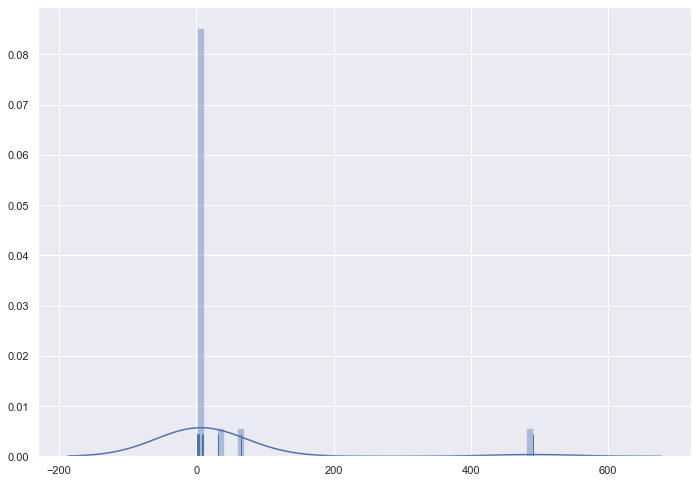

In [23]:
sns.distplot( counts_freq, bins=50,rug=True )

### Entities graph
edges = all entities with more than one count

In [24]:
ent

NameError: name 'ent' is not defined

In [25]:
df['bul edges']= df['bul ents text']

In [26]:
n=4
norm = scale
mat = pd.DataFrame(df['bul edges'].apply(Counter).to_dict()).T
arc = Archetypes(mat.fillna(0),n)

0    17.042193
1    19.448015
2    16.874562
3     9.213033
dtype: float64


0         1         2         3
Provides             1.000000  0.000000  0.000875  0.348498
Facilitates          0.191124  0.269710  0.000000  0.000000
Coordinates          0.157270  0.085765  0.028217  0.000000
  Primary Duties     0.098475  0.000000  0.000000  0.000000
Utilizes             0.097785  0.037425  0.717267  0.000000
Initiates            0.091505  0.094470  0.165458  0.000000
Nurse Administrator  0.086229  0.000000  0.000000  0.000000
Provides Nurse       0.086229  0.000000  0.000000  0.000000

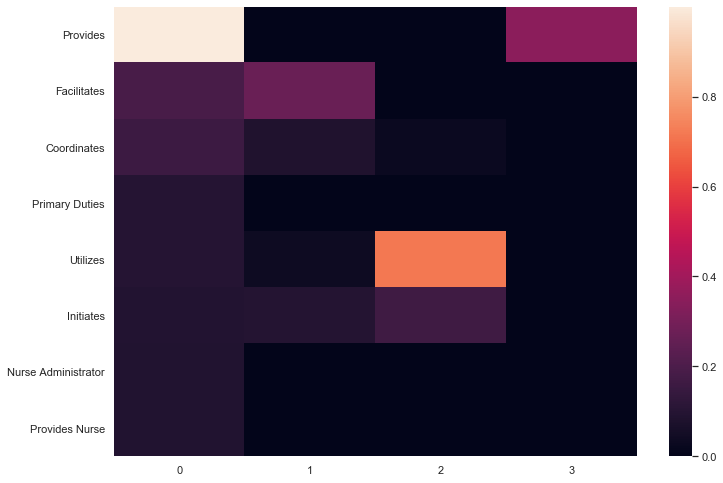

In [27]:
def plarc(n,arc=arc):
    print(arc.f.T.apply(sum))
    a = arc.f.T.apply(norm).sort_values(by=n,ascending=False)[:8]
    sns.heatmap(a)
    return a

plarc(0)

## POS - PARTS OF SPEECH

**SUMMARY 3/17/20:** Preliminary tests indicate OK result for NOUN. Might be sufficient for running two archetypes. 

In [39]:
from pprint import pprint


# pos = ['ADJ','NOUN', 'PROPN','VERB']


candidates_dic  = {'pos_':['ADJ','NOUN', 'PROPN','VERB']}

def screen_tokens(doc, candidates = ['ADJ','NOUN', 'PROPN','VERB'] , split_sentences = False):
    
    if split_sentences:
        
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                if token.pos_ in candidates and token.is_stop is False:
                    selected_words.append(token)
            sentences.append(selected_words)
        return(sentences)        
    
    else:
        
        selected_tokens = []
        for token in doc:
            if token.pos_ in candidates:
                selected_tokens += [token]
        return(selected_tokens)

screen_token_sents = lambda x: screen_tokens(x,split_sentences=True)
    
df['nlp bul'].head().apply(lambda x: screen_tokens(x,['NOUN']))

0    [nursing, activities, quality, care, flow, pat...
1    [risk, members, conditions, care, plan, collab...
2    [Nurse, portion, client, placement, Update, cl...
3    [oversight, monitoring, medication, delivery, ...
4    [Staff, assistance, activities, living, accord...
Name: nlp bul, dtype: object

In [40]:
# SUMMARY OF ALL TOKENS IN ALL DOCS
aaa = []
for doc in df['nlp bul'].apply(screen_tokens):
    for token in doc:
        aaa += [[token.text, token.lemma_, token.pos_, token.tag_, token.dep_]]
bbb = pd.DataFrame(aaa,columns=['txt','lemma','pos','tag','dep'])
ccc = bbb.groupby('pos').agg(set)
ccc

txt  \
pos                                                        
ADJ    {willing, operative, attainment, verbal, real,...   
NOUN   {in, promulgation, effects, multitasking, infr...   
PROPN  {Policies, Monitor, CDC, Assume, Patient, Skil...   
VERB   {recognized, transmitting, enhances, move, Mon...   

                                                   lemma  \
pos                                                        
ADJ    {oasis, willing, operative, attainment, verbal...   
NOUN   {in, promulgation, multitasking, euthanasia, s...   
PROPN  {winter, productivity, cps, comply, major, pos...   
VERB   {remove, move, threaten, comply, get, result, ...   

                                       tag  \
pos                                          
ADJ    {JJR, PDT, AFX, WDT, JJS, PRP$, JJ}   
NOUN                         {WP, NN, NNS}   
PROPN                          {NNP, NNPS}   
VERB     {VB, VBZ, VBP, MD, VBN, VBG, VBD}   

                                                     dep  
pos                                                       
ADJ    {conj, nummod, poss, nsubj, compound, preconj,...  
NOUN   {conj, nummod, poss, cc, nsubj, compound, quan...  
PROPN  {parataxis, appos, nsubjpass, pobj, dep, dobj,...  
VERB   {conj, nsubj, compound, relcl, ccomp, advcl, p...

0    91.961699
1    68.471528
dtype: float64


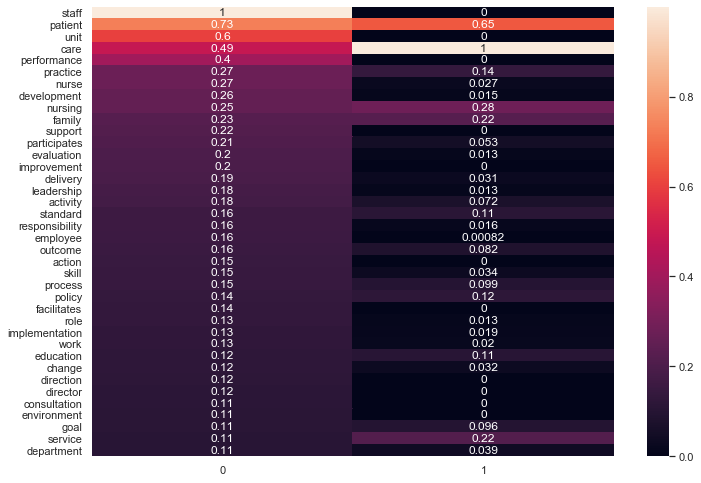

0    91.961699
1    68.471528
dtype: float64


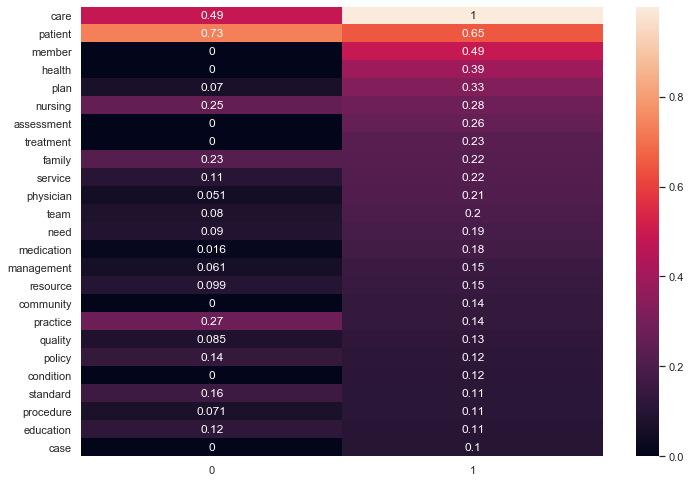

In [60]:
candidates = ['NOUN']
df['pos']= df['nlp bul'].apply(lambda x: screen_tokens(x, candidates = candidates))
df['pos edges']=df['pos'].apply(lambda x: [Lem(token.text).lower() for token in x])

mat = pd.DataFrame(df['pos edges'].apply(Counter).to_dict()).T

n=2
norm = scale
arc = Archetypes(mat.fillna(0),n)

def plarc(arc,n,cutoff):
    print(arc.f.T.apply(sum))
    a = arc.f.T.apply(norm).sort_values(by=n,ascending=False)
    a = a[a[n] >= cutoff ]
    sns.heatmap(a,annot=True)
    plt.show()
    return 


plarc(arc,0,0.1)
plarc(arc,1,0.1)

## DEPENDENCIES

In [402]:
# doc = df['nlp bul'][0]
# sent = list(doc.sents)[3]
aaa = []
for doc in df['nlp bul']:
    for token in doc:
        aaa += [[token.text, token.lemma_, token.pos_, token.tag_, token.dep_]]
bbb = pd.DataFrame(aaa,columns=['txt','lemma','pos','tag','dep'])
ccc = bbb.groupby('dep').agg(set)
ccc

txt  \
dep                                                            
                                                     {  ,  }   
ROOT       {recovery, denials, programs, survey, Dissemin...   
acl        {occurring, see, solving, resulting, admitted,...   
acomp      {reliant, eligible, appropriate, informative, ...   
advcl      {transporting, see, arise, solving, redesigned...   
advmod     {Technician-, fast, reactively, when, soon, se...   
agent                                                   {by}   
amod       {certifying, Formulary, solving, informative, ...   
appos      {USD, denials, data, CBCN, infants, Newnan, pr...   
attr       {individual, way, same, Citizen, takes, repres...   
aux        {have, be, May, Has, can, is, should, Helps, c...   
auxpass    {be, feeling, 's, Is, been, is, were, feels, b...   
case                                             {'s, ', w/}   
cc         {*, AAAHC);and, And, Or, nor, n, as, AND, and/...   
ccomp      {established, /educates, Ensures, check, appro...   
compound   {recovery, denials, BHCF, initiates, signal, s...   
conj       {uniqueness, recovery, denials, distress, inse...   
csubj      {monitoring, Communicating, rounding, Working,...   
csubjpass  {Assuring, Working, verify, Ensure, Avoid, Ens...   
dative     {residents, competency, for, to, them, Nurse, ...   
dep        {Type, Adheres, provide, Schedule, etc, Make, ...   
det        {Some, every, both, The, Every, the, a, |, tha...   
dobj       {uniqueness, recovery, denials, programs, ship...   
expl                                          {There, there}   
intj       {Contributes, Time, Recognizes, Nurse(Rn, unit...   
mark       {until, whether, for, after, If, if, While, Wi...   
meta                                           {A, 5, 1-, 3}   
neg                              {NOT, not, and/or, Not, no}   
nmod       {USD, Completion, CFR, data, ONN, Overnight, D...   
npadvmod   {physician, data, industry, action, Time, devi...   
nsubj      {denials, Completion, data, Trainings, package...   
nsubjpass  {residents, Ensures, applicants, Collaborates,...   
nummod     {19, 4, 12, 2-day, 180, 8, 5, 10, 65, 6A-6P, 1...   
oprd       {Communicate, appropriate, clean, current, div...   
parataxis  {pass, be, Holly, Make, practice, draw, TO, sm...   
pcomp      {established, reading, needing, monitoring, de...   
pobj       {recovery, denials, infants, programs, survey,...   
poss       {residents, applicants, physician, Master, con...   
preconj                                       {either, both}   
predet                                           {all, such}   
prep       {employing, Along, of, TO, Between, 5, by, ins...   
prt        {up, in, on, through, down, forth, off, out, O...   
punct      {-EMPLOYEES, .**Will, -Sign, of, .., -5:00, /,...   
quantmod   {Charge/, $, up, 17, Up, a, to, 3, Travel, s, ...   
relcl      {appropriate, arise, interact, keep, protect, ...   
xcomp      {transporting, see, appropriate, check, utiliz...   

                                                       lemma  \
dep                                                            
                                                     {  ,  }   
ROOT       {recovery, advises, recogniz, see, note, data,...   
acl        {aim, see, physician, appropriate, utilize, th...   
acomp      {reliant, eligible, appropriate, informative, ...   
advcl      {see, note, arise, show, adapt, face, confer, ...   
advmod     {fast, reactively, when, appropriate, securely...   
agent                                                   {by}   
amod       {curious, note, undertake, informative, biolog...   
appos      {note, initiates, clerk, association, collabor...   
attr       {disease, individual, director, way, mandatory...   
aux        {must, have, be, to, will, could, shall, do, o...   
auxpass                                           {feel, be}   
case                                             {'s, ', w/}   
cc         {*, nor, n, a

In [135]:
pprint(ccc['lemma'].apply(lambda x: ', '.join(list(x))).to_dict())

{'': '\n,  ',
 'ROOT': 'see, initiates, correlates, suspension, association, 10, '
         'collaboration, agent, title, statistic, duty, day, round, function, '
         'reaction, certificate, facilitate, streamline, conduct, insure, '
         'visit, registration, throughput, information, make, provide, '
         'collect, drive, designate, analyzes, range, manage, supply, '
         'evaluate, puncture, updates, development, manages, responsibility, '
         'reimbursement, nurse, staff, reviews, autonomy, upholds, market, '
         'differentiate, observe, screen, organize, procure, service, '
         'assignment, accepts, analyze, uses, receive, milieu, ensures, '
         'complie, contact, pacu, represent, speak, ln, member, willing, '
         'detail, offer, generates, leadership, need, live, remember, with, *, '
         'client, creates, add, completion, coverage, as, commitment, '
         'maintains, thinking, 17, 23, open, employee, manager, initiate, '
         '

In [658]:
df['nlp bul'][0]

Office

In [677]:
result = []
for token in df['nlp bul'][1]:
    result += [[token,token.dep_,token.tag_]]
aaa = pd.DataFrame(result,columns=['token','dep_','tag_'])

In [ ]:
result2 = []
aaa = list(df['nlp bul'][1])
while aaa:
    print(pop(aaa))

In [678]:
bbb = aaa[aaa['dep_'] == 'compound']
idx = bbb.index

result = []
for idx in bbb.index:
    if idx+1 not in bbb.index:
        result += [idx+1]
ccc = bbb.append(aaa.loc[result]).sort_index()
ccc

token      dep_  tag_
0                  ACO  compound   NNP
1                Nurse  compound   NNP
2                 Case  compound   NNP
3           Specialist  compound   NNP
4                    -     punct  HYPH
...                ...       ...   ...
1088  reconcilliations      conj   NNS
1095          settings  compound   NNS
1096           accross      pobj    VB
1098               age  compound    NN
1099            groups  npadvmod   NNS

[270 rows x 3 columns]

In [679]:
ddd = pd.Series(ccc.index[1:] - ccc.index[:-1])
idx1 = ddd[ddd != 1].index -1
eee = ddd[1:][ddd[1:].values != ddd[:-1].values]
idx2 = eee[eee==1].index -1
idx2 = idx2+1
comp_spans = [[0,idx1[0]]]+list(np.transpose([idx1,idx2]))   
[ccc['token'].values[s[0]:s[1]]for s in comp_spans]

[array([ACO, Nurse, Case], dtype=object),
 array([Specialist, -], dtype=object),
 array([New, Career], dtype=object),
 array([Health, Insurance], dtype=object),
 array([Case, Manager], dtype=object),
 array([risk, members], dtype=object),
 array([care, plan], dtype=object),
 array([Care, Physician], dtype=object),
 array([cost, effective], dtype=object),
 array([quality, outcome], dtype=object),
 array([Case, Manager], dtype=object),
 array([Case, Manager], dtype=object),
 array([care, managers], dtype=object),
 array([risk, members], dtype=object),
 array([care, plans], dtype=object),
 array([member, attaining], dtype=object),
 array([medication, reconciliations], dtype=object),
 array([healthcare, services], dtype=object),
 array([plan, goals], dtype=object),
 array([community, services], dtype=object),
 array([Social, Workers], dtype=object),
 array([care, plans], dtype=object),
 array([health, needs], dtype=object),
 array([health, needs], dtype=object),
 array([care, team], dtype=

Int64Index([8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 29, 31, 33], dtype='int64')

In [564]:
fig = go.Figure(data=[go.Table(
    cells=dict(values=aaa,
               fill_color='lavender',
               align='left'))
])

fig.show()

In [57]:
ccc.loc[3].values

array(['acomp', list([Responsible]), list(['ADJ'])], dtype=object)

In [ ]:
{'not needed':{}}}
    
    
    

compound

In [20]:
spacy.explain('nsubjpass')

'nominal subject (passive)'

In [159]:
df['nlp']=df.head()['bullets for'].apply(nlp)
df['nlp'].iloc[1]

*### HEAD: The Case Manager proactively identifies and assesses high-risk members, with complex conditions, and develops and implements an individualized, coordinated care plan, in collaboration with member and primary Care Physician and/or specialist, to ensure a cost effective, quality outcome, focused in the ambulatory setting. The Case Manager assists the member in attaining and/or maintaining an optimal functional status. The Case Manager is responsible for all activities related to ###
* Working directly with members, their physicians, and other care managers to assess the needs of high-risk members and develop customized, proactive care plans resulting in the member attaining and/or maintaining an optimal functional status. Performs medication reconciliations.
* Authorizing services, coordinating care, ensuring timeliness and coordinating healthcare services, in compliance with documented care plan goals and objectives, and Department and regulatory standards, seeking supplement

In [42]:
list(doc.sents)

[*### head: you will be responsible for ###
 * performs general nursing activities, ensuring quality care and efficient/timely flow of patients.,
 * oversees appointment scheduling to ensure preferences are given to patients in emergency situations.,
 escorts patients to exam room within 15 minutes of arrival time as logged on the sign in sheet.,
 * accurately performs and records in patient chart height, weight, temperature, blood pressure, respiration, and pulse.,
 screens complete and appropriate medical information from patient.,
 * assists patients for exam, having them in proper undress.,
 instructs patients clearly in collection of samples and tests needed.,
 collects specimens within 10 mins of being ordered by the physician.,
 performs vena punctures within timely manner.,
 * prepares equipment and aids physicians during treatment, examination and testing of patients.,
 maintains and securely controls medical supplies and medication counts, with adequate supporting records.]

In [71]:
import spacy

nlp = spacy.load("en_core_web_sm")

text = "It’s official: Apple is the first U.S. public company to reach a $1 trillion market value"

# Process the text
doc = nlp(text)

In [93]:
[(ent.text,ent.label_) for ent in doc.ents]

[('Apple', 'ORG'),
 ('first', 'ORDINAL'),
 ('U.S.', 'GPE'),
 ('$1 trillion', 'MONEY')]

In [125]:
token  = doc[2]
token

official

In [136]:
token.lemma_

'official'

In [110]:
a = 5
doc.__dir__()

['__repr__',
 '__str__',
 '__iter__',
 '__init__',
 '__len__',
 '__getitem__',
 '__new__',
 'set_extension',
 'get_extension',
 'has_extension',
 'remove_extension',
 '__unicode__',
 '__bytes__',
 'char_span',
 'similarity',
 'to_array',
 'count_by',
 '_realloc',
 'from_array',
 'get_lca_matrix',
 'to_disk',
 'from_disk',
 'to_bytes',
 'from_bytes',
 'extend_tensor',
 'retokenize',
 '_bulk_merge',
 'merge',
 'print_tree',
 '_',
 'is_sentenced',
 'doc',
 'has_vector',
 'vector',
 'vector_norm',
 'text',
 'text_with_ws',
 'ents',
 'noun_chunks',
 'sents',
 'mem',
 'vocab',
 '_vector',
 '_vector_norm',
 'tensor',
 'cats',
 'user_data',
 'is_tagged',
 'is_parsed',
 'sentiment',
 'user_hooks',
 'user_token_hooks',
 'user_span_hooks',
 '_py_tokens',
 'noun_chunks_iterator',
 '__doc__',
 '__pyx_vtable__',
 '__reduce__',
 '__setstate__',
 '__hash__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__subc

In [88]:
list(doc.vocab.strings)

['""',
 '#',
 '$',
 "''",
 ',',
 '-LRB-',
 '-RRB-',
 '.',
 ':',
 'ADD',
 'AFX',
 'BES',
 'CC',
 'CD',
 'DT',
 'EX',
 'FW',
 'GW',
 'HVS',
 'HYPH',
 'IN',
 'JJ',
 'JJR',
 'JJS',
 'LS',
 'MD',
 'NFP',
 'NIL',
 'NN',
 'NNP',
 'NNPS',
 'NNS',
 'PDT',
 'PRP',
 'PRP$',
 'RB',
 'RBR',
 'RBS',
 'RP',
 'SP',
 'TO',
 'UH',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WDT',
 'WP',
 'WP$',
 'WRB',
 'XX',
 '_SP',
 '``',
 '-PRON-',
 'be',
 '\t',
 'en',
 '\n',
 ' ',
 '")',
 '"',
 "'",
 "'Cause",
 'because',
 "'cause",
 'use',
 "'Xxxxx",
 "'Cos",
 "'cos",
 'Cos',
 "'Xxx",
 "'Coz",
 "'coz",
 'Coz',
 "'Cuz",
 "'cuz",
 'Cuz',
 "'S",
 "'s",
 "'X",
 "'bout",
 'about',
 'out',
 "'xxxx",
 'cos',
 "'xxx",
 'coz',
 'cuz',
 "'d",
 "'x",
 "'em",
 'them',
 "'xx",
 "'ll",
 'will',
 "'nuff",
 'enough',
 'uff',
 "'re",
 'are',
 '(*_*)',
 '(',
 '_*)',
 '(-8',
 '(-d',
 '(-:',
 '(-;',
 '(-_-)',
 '_-)',
 '(._.)',
 '_.)',
 '(:',
 '(;',
 '(=',
 '(>_<)',
 '_<)',
 '(^_^)',
 '_^)',
 '(o:',
 '(x:',
 '(¬_¬)',
 '_¬)',
 '(ಠ_

In [81]:
spacy.explain('GPE')

'Countries, cities, states'

In [50]:
import tensorflow as tf
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub

In [61]:
1+1